# Introduction

The data analyzed was captured by the 186 cameras of cita.lu between 19/11/2019 and 26/12/2019 on the Luxembourg motorways.

Data for each camera is updated every 5 minutes.

For this period, this represents a data set of 1,887,379 records.

If we extrapolate to 1 year, this represents approximately 18,130,000 records.

The 3 measurements available for each camera every 5 minutes are:
- Average speed in km/h
- Traffic concentration in percentage
- Traffic flow in number of cars per hour



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import dates
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime
from tensorflow import keras
import math as math
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
plt.style.use('seaborn')

        
lux = (49.61167 , 6.13)
highway = ['A1', 'A3', 'A4', 'A6', 'A7', 'A13', 'B40']        
directory = 'D:/Tunf/NOO/DATN/test/traffic_flow_prediction/data/'
files=['datexDataA1.csv','datexDataA3.csv','datexDataA4.csv','datexDataA6.csv','datexDataA7.csv','datexDataA13.csv','datexDataB40.csv']

## Utility functions used in this notebook

In [2]:
# Describe Data
def describeData(data):
    print("shape = {}".format(data.shape))
    description = data.describe().T
    description["isNull"] = data.isnull().sum()
    print(description)
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

# filter data     
def getFilteredData(data,idCamera,indexMin='2000-01-01 00:00:00+0000',indexMax='2030-01-01 00:00:00+0000'):
    result = data[(data.index>indexMin) ]
    result = result[(result.index<indexMax)]
    result = result[(result['id'] == idCamera)].fillna(method = 'ffill')
    return result

def getFilteredDataByHighway(data,road,direction='outboundFromTown',indexMin='2000-01-01 00:00:00+0000',indexMax='2030-01-01 00:00:00+0000'):
    result = data[(data.index>indexMin) ]
    result = result[(result.index<indexMax)]
    result = result[(result['direction'] == direction)]
    result = result[(result['road'] == road)].fillna(method = 'ffill')
    return result

# Get Previous Camera Dict
def getPreviousCamDict(camera):
    prev_cam = {}
    for road in camera['road'].unique():
        fromLux = camera.loc[(camera['road']==road)&(camera['direction']=='outboundFromTown')].copy()
        toLux = camera.loc[(camera['road']==road)&(camera['direction']=='inboundTowardsTown')].copy()
        fromLux.sort_values(by=['direction_dist'],inplace=True,ascending = True)
        toLux.sort_values(by=['direction_dist'],inplace=True,ascending = False)
        
        toLux['previd']=toLux['id'].shift(1)
        toLux.dropna(inplace=True)
        fromLux['previd']=fromLux['id'].shift(1)
        fromLux.dropna(inplace=True)
        
        for lux in [fromLux,toLux]:
            if lux.shape[0]>0:
                for index, row in lux.iterrows():
                    prev_cam[row['id']] = row['previd']  
    return prev_cam    
# Graph
def getGraph(cameras,direction = "outboundFromTown"):
    G = nx.DiGraph(label="TRAFFIC")
    dict_previous_cam = getPreviousCamDict(cameras)
    for i, rowi in cameras.loc[cameras["direction"]==direction].iterrows():
        G.add_node(rowi['id'],key=rowi['id'],label="id",road=rowi['road'],latitude=rowi['latitude'],longitude=rowi['longitude'])
        previous = dict_previous_cam.get(rowi['id'])
        if previous != None:
            G.add_edge(previous,rowi['id'])            
    return G

def printMap(G,title=""):
    colors=[]
    pos={}
    pos2={}
    labels={}
    dict_colors = {'A1':'orange', 'A3':'blue', 'A4':'red', 'A6':'green', 'A7':'black', 'A13':'yellow', 'B40':'cyan'}    
    fig, ax = plt.subplots(figsize=(12,12), dpi=200)  
    # graph    
    for e in G:
        pos[e]=(G.nodes[e]['longitude'],G.nodes[e]['latitude'])
        pos2[e]=(G.nodes[e]['longitude']+0.010,G.nodes[e]['latitude']+0.001)
        new = e.split(".")
        labels[e] = new[2]
        colors.append(dict_colors.get(G.nodes[e]['road']))
    # nodes
    nx.draw_networkx_nodes(G, pos,node_size=50,node_color=colors)
    nx.draw_networkx_edges(G, pos, node_size=50, arrowstyle='->',arrowsize=20)
    # labels
    nx.draw_networkx_labels(G, pos2, labels= labels,font_size=10)
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in dict_colors.values()]
    plt.legend(markers, dict_colors.keys(), numpoints=1,loc='upper left') 
    plt.title(title)
    plt.show()
    
def plot_long_serie(data,title='',label='',xlabel='Time',ylabel='', dpi=100):
    days = dates.DayLocator()
    dfmt = dates.DateFormatter('%b %d')
    fig, ax = plt.subplots(figsize=(16,9), dpi=dpi)  
    ax.set_title(title)
    ax.plot(data.index.values, data.values, label=label,linewidth=1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.xaxis.set_major_locator(days)
    ax.xaxis.set_major_formatter(dfmt)
    ax.xaxis.set_tick_params(which='major',labelsize=7)
    ax.grid(True)
    plt.show()

def plot_day_traffic(data0,data1,titles,dpi=100):    
    fig, axes = plt.subplots(2, 7, figsize=(16,9),dpi=dpi)    
    yLimite=data0.max()*1.1
    for i, a in zip(range(7), axes[0].ravel()):
        df = data0[data0.index.dayofweek==i]
        df.index = [df.index.time,df.index.date]
        df = df.unstack().interpolate()
        for column in df:
            a.plot(df.index.map(lambda x: (x.minute+x.hour*60)/60 ), df[column], marker='', linewidth=1, alpha=0.9) 
            a.set_ylim(0,yLimite)
            a.set_title(titles[i])
            a.set_xticks(np.arange(0,25,3))
    yLimite=data1.max()*1.1             
    for i, a in zip(range(7), axes[1].ravel()):
        df = data1[data1.index.dayofweek==i]
        df.index = [df.index.time,df.index.date]
        df = df.unstack().interpolate()
        for column in df:
            a.plot(df.index.map(lambda x: (x.minute+x.hour*60)/60 ), df[column], marker='', linewidth=1, alpha=0.9)                     
            a.set_ylim(0,yLimite)
            a.set_xticks(np.arange(0,25,3))
    plt.show()
    

# Draw multiple plots 
def plot_mult(datas,labels,xlabel,ylabel,dpi=100):
    days = dates.DayLocator()
    hours = dates.HourLocator(byhour=[0,6,12,18])
    dfmt = dates.DateFormatter('%b %d')
    fig, ax = plt.subplots(figsize=(16,9), dpi=dpi)  
    
    for i, data in enumerate(datas):
        plabel = labels[i]
        ax.plot(data.index.values, data.values, label=plabel,linewidth=1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.xaxis.set_major_locator(days)
    ax.xaxis.set_major_formatter(dfmt)
    ax.xaxis.set_minor_locator(hours)
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%H'))
    ax.xaxis.set_tick_params(which='major', pad=15,labelsize=7)
    ax.xaxis.set_tick_params(which='minor', labelsize=4)
    ax.grid(True)
    plt.show()


# Load data

In [3]:
frames=[]
for file in files:
    #print(file + ' start')
    df = pd.read_csv(directory+file, parse_dates = False, header = None,sep=';')
    df.columns=['id','time','latitude','longitude','direction','road','trafficStatus','avgVehicleSpeed','vehicleFlowRate','trafficConcentration']
    df.loc[df['time'].str.len()<25,'time']=pd.NaT
    df['time'] = pd.to_datetime(df['time'],errors='coerce',utc=False)  
    df['time'] = df['time'].fillna(method = 'ffill')
    #df.index = df['time','id']
    df.set_index(['time','id'],drop=False,inplace=True)
    df=df[~df.index.duplicated()]
    df.set_index(['time'],drop=False,inplace=True)
    df['dayofweek'] = df.index.dayofweek
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    new = df["id"].str.split(".", expand = True) 
    df['highway']=new[0]
    df['direction_code']=new[1]
    df['direction_dist']=pd.to_numeric(new[2])    
    # df=df[~camera.index.duplicated()]
    frames.append(df)
    print(file + ': end loading {} rows '.format(df.shape[0]))
data = pd.concat(frames)

data.dropna(inplace=True)
# Build camera dataframe
camera = data[['id','latitude','longitude','direction_dist','direction_code','road','direction']]
camera.index = camera['id']
camera=camera[~camera.index.duplicated()]
del(new,frames,file,df)
data.head(5)

datexDataA1.csv: end loading 394420 rows 
datexDataA3.csv: end loading 245249 rows 
datexDataA4.csv: end loading 245387 rows 
datexDataA6.csv: end loading 459756 rows 
datexDataA7.csv: end loading 256056 rows 
datexDataA13.csv: end loading 490360 rows 
datexDataB40.csv: end loading 106580 rows 


id                      time   latitude  \
time                                                                            
2019-11-19 07:39:00+01:00    A1.GT.24538 2019-11-19 07:39:00+01:00  49.667915   
2019-11-19 07:39:00+01:00    A1.GT.26600 2019-11-19 07:39:00+01:00  49.679363   
2019-11-19 07:39:00+01:00    A1.GT.15400 2019-11-19 07:39:00+01:00  49.640390   
2019-11-19 07:39:00+01:00  A1.TTHOG.2009 2019-11-19 07:39:00+01:00  49.578068   
2019-11-19 07:39:00+01:00    A1.TG.16951 2019-11-19 07:39:00+01:00  49.643085   

                           longitude           direction road trafficStatus  \
time                                                                          
2019-11-19 07:39:00+01:00   6.377110    outboundFromTown   A1      freeFlow   
2019-11-19 07:39:00+01:00   6.399515    outboundFromTown   A1      freeFlow   
2019-11-19 07:39:00+01:00   6.263833    outboundFromTown   A1      freeFlow   
2019-11-19 07:39:00+01:00   6.150946  inboundTowardsTown   A1      freeFlow   
2019-11-19 07:39:00+01:00   6.284836  inboundTowardsTown   A1    impossible   

                           avgVehicleSpeed  vehicleFlowRate  \
time                                                          
2019-11-19 07:39:00+01:00            127.0              313   
2019-11-19 07:39:00+01:00            120.0              448   
2019-11-19 07:39:00+01:00            109.0              274   
2019-11-19 07:39:00+01:00             86.0             2171   
2019-11-19 07:39:00+01:00             29.0             3206   

                           trafficConcentration  dayofweek  day  hour highway  \
time                                                                            
2019-11-19 07:39:00+01:00                   0.0          1   19     7      A1   
2019-11-19 07:39:00+01:00                   1.0          1   19     7      A1   
2019-11-19 07:39:00+01:00                   0.0          1   19     7      A1   
2019-11-19 07:39:00+01:00                  10.0          1   19     7      A1   
2019-11-19 07:39:00+01:00                   2.0          1   19     7      A1   

                          direction_code  direction_dist  
time                                                      
2019-11-19 07:39:00+01:00             GT           24538  
2019-11-19 07:39:00+01:00             GT           26600  
2019-11-19 07:39:00+01:00             GT           15400  
2019-11-19 07:39:00+01:00          TTHOG            2009  
2019-11-19 07:39:00+01:00             TG           16951

In [1]:
a = 394420  + 245249  +245387 +459756 +256056 +490360 +106580 
a

2197808

In [4]:
print("min index is",data.index.min())
print("max index is",data.index.max())
nRow, nCol = data.shape
print(f'There are {nRow} rows and {nCol} columns in the dataset')

min index is 2019-11-19 07:39:00+01:00
max index is 2019-12-26 09:34:00+01:00
There are 1887379 rows and 16 columns in the dataset


In [5]:
nRow, nCol = camera.shape
print(f'There are {nRow} rows and {nCol} columns in camera dataset')
camera.head(5)

There are 186 rows and 7 columns in camera dataset


id   latitude  longitude  direction_dist  \
id                                                                   
A1.GT.24538      A1.GT.24538  49.667915   6.377110           24538   
A1.GT.26600      A1.GT.26600  49.679363   6.399515           26600   
A1.GT.15400      A1.GT.15400  49.640390   6.263833           15400   
A1.TTHOG.2009  A1.TTHOG.2009  49.578068   6.150946            2009   
A1.TG.16951      A1.TG.16951  49.643085   6.284836           16951   

              direction_code road           direction  
id                                                     
A1.GT.24538               GT   A1    outboundFromTown  
A1.GT.26600               GT   A1    outboundFromTown  
A1.GT.15400               GT   A1    outboundFromTown  
A1.TTHOG.2009          TTHOG   A1  inboundTowardsTown  
A1.TG.16951               TG   A1  inboundTowardsTown

# Print the cameras map

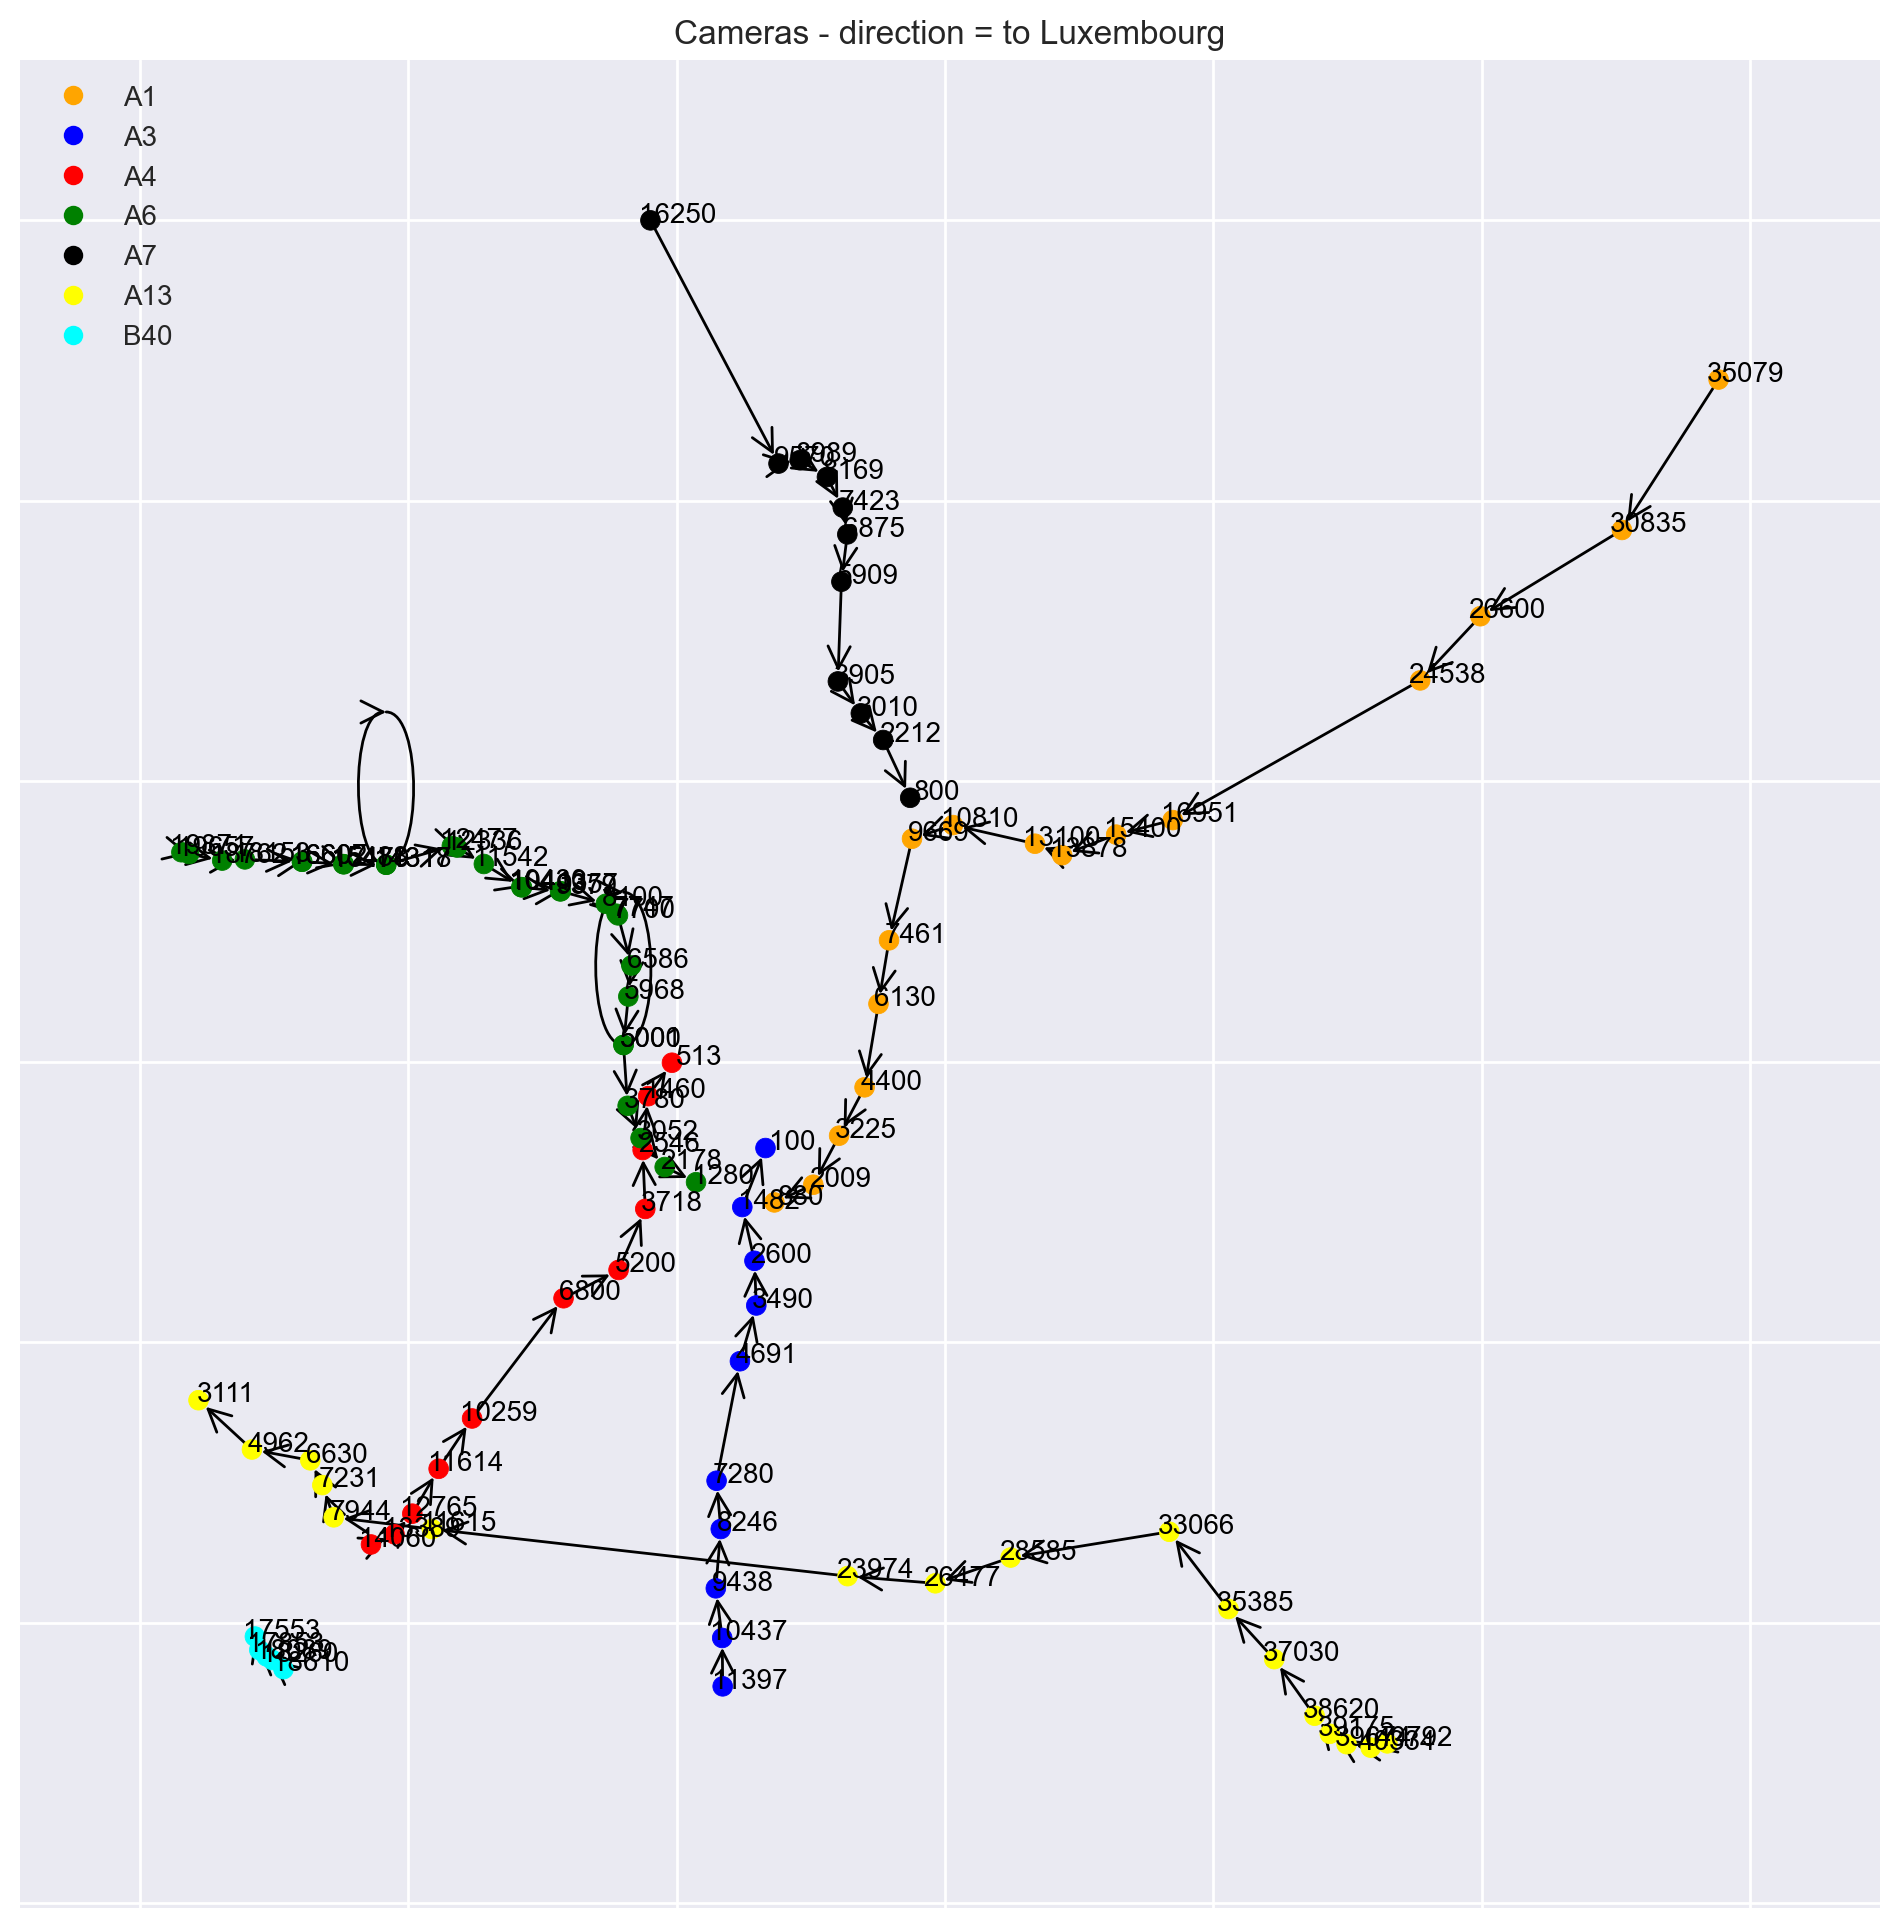

In [6]:
# print the cameras map
GFrom = getGraph(camera,direction="outboundFromTown")
GTo = getGraph(camera,direction="inboundTowardsTown")

printMap(GTo,title="Cameras - direction = to Luxembourg")

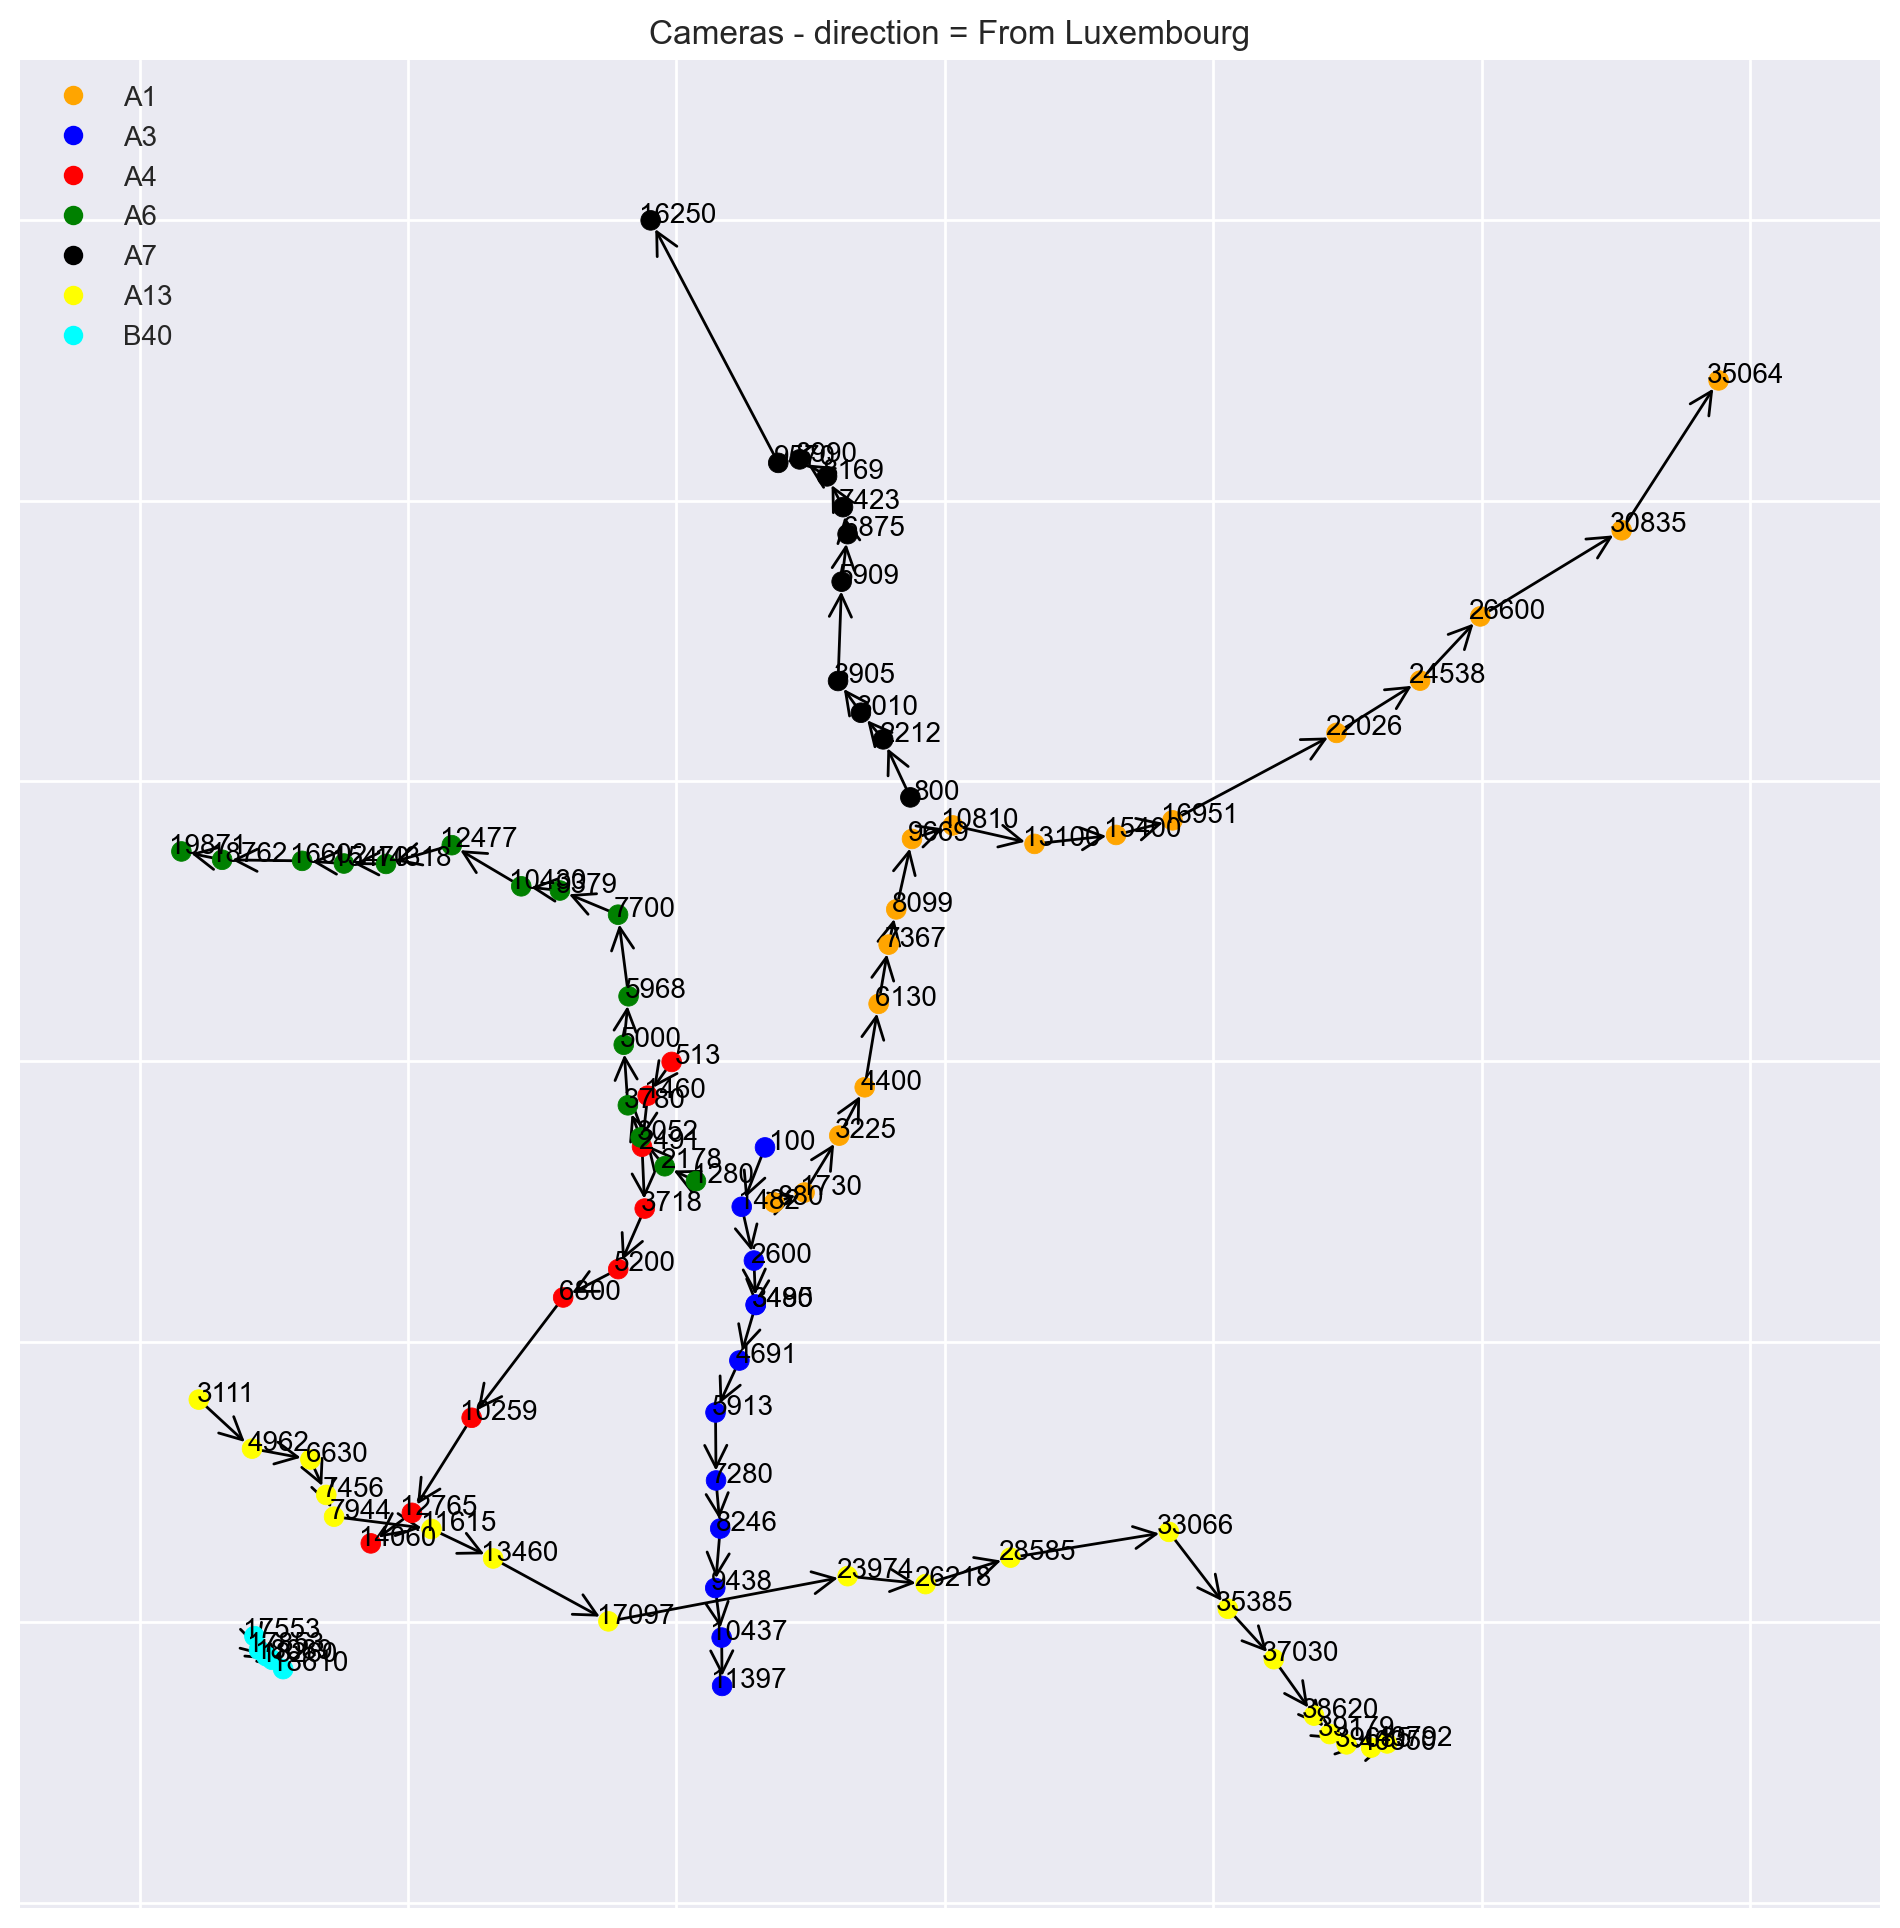

In [12]:
printMap(GFrom,title="Cameras - direction = From Luxembourg")

# Exploratory data analysis
> &#171;For this graphic exploration, we will focus on the camera at kilometer 11 of the A3, this camera is located on the border between France and Luxembourg. Traffic at the border experiences daily overloads in the morning towards Luxembourg and in the evening towards France.&#187;

In [7]:
road = 'A3'
  
fromLuxCam = 'A3.VM.11397'
toLuxCam = 'A3.MV.11397'
fromDate = '2019-11-25 00:00:00+0000'
toDate = '2019-12-23 00:00:00+0000'

fromLux = getFilteredData(data,fromLuxCam,fromDate,toDate)
toLux = getFilteredData(data,toLuxCam,fromDate,toDate)

fromLux_rolling_avg = fromLux.avgVehicleSpeed.rolling(window=10,center=True).mean()
fromLux_rolling_flow = fromLux.vehicleFlowRate.rolling(window=10,center=True).mean()
fromLux_rolling_traf = fromLux.trafficConcentration.rolling(window=10,center=True).mean()
fromLux_rolling_avg.dropna(inplace=True)
fromLux_rolling_flow.dropna(inplace=True)
fromLux_rolling_traf.dropna(inplace=True)

toLux_rolling_avg = toLux.avgVehicleSpeed.rolling(window=10,center=True).mean()
toLux_rolling_flow = toLux.vehicleFlowRate.rolling(window=10,center=True).mean()
toLux_rolling_traf = toLux.trafficConcentration.rolling(window=10,center=True).mean()
toLux_rolling_avg.dropna(inplace=True)
toLux_rolling_flow.dropna(inplace=True)
toLux_rolling_traf.dropna(inplace=True)

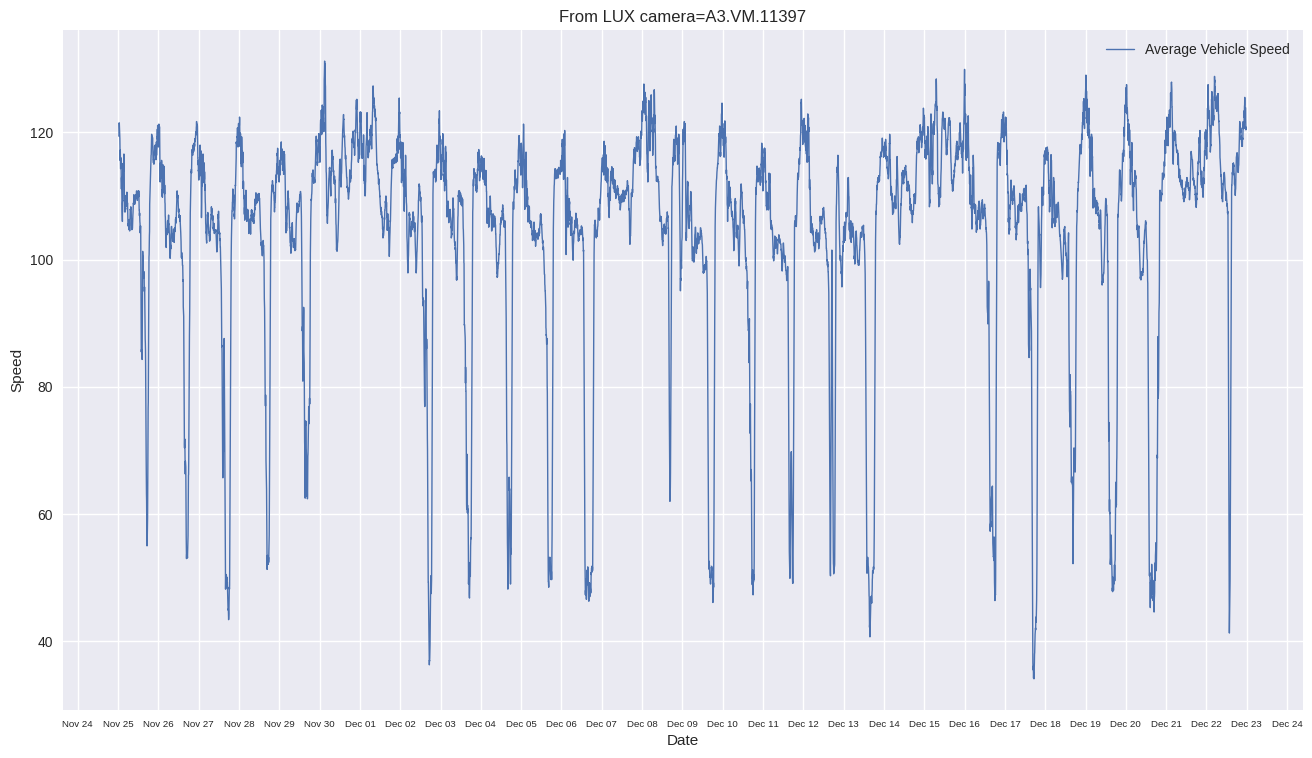

In [9]:
plot_long_serie(fromLux_rolling_avg,title='From LUX camera={}'.format(fromLuxCam),label='Average Vehicle Speed',xlabel='Date',ylabel='Speed')

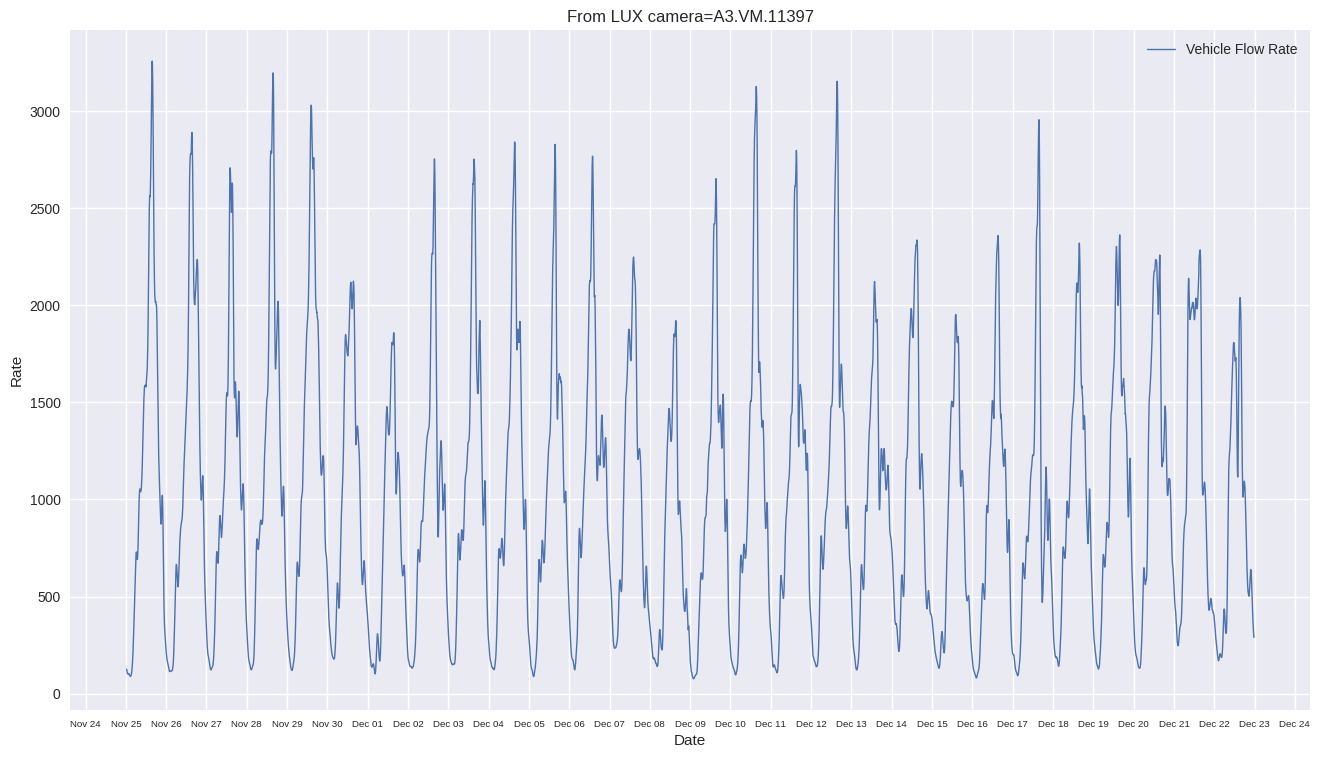

In [10]:
plot_long_serie(fromLux_rolling_flow,title='From LUX camera={}'.format(fromLuxCam),label='Vehicle Flow Rate',xlabel='Date',ylabel='Rate')

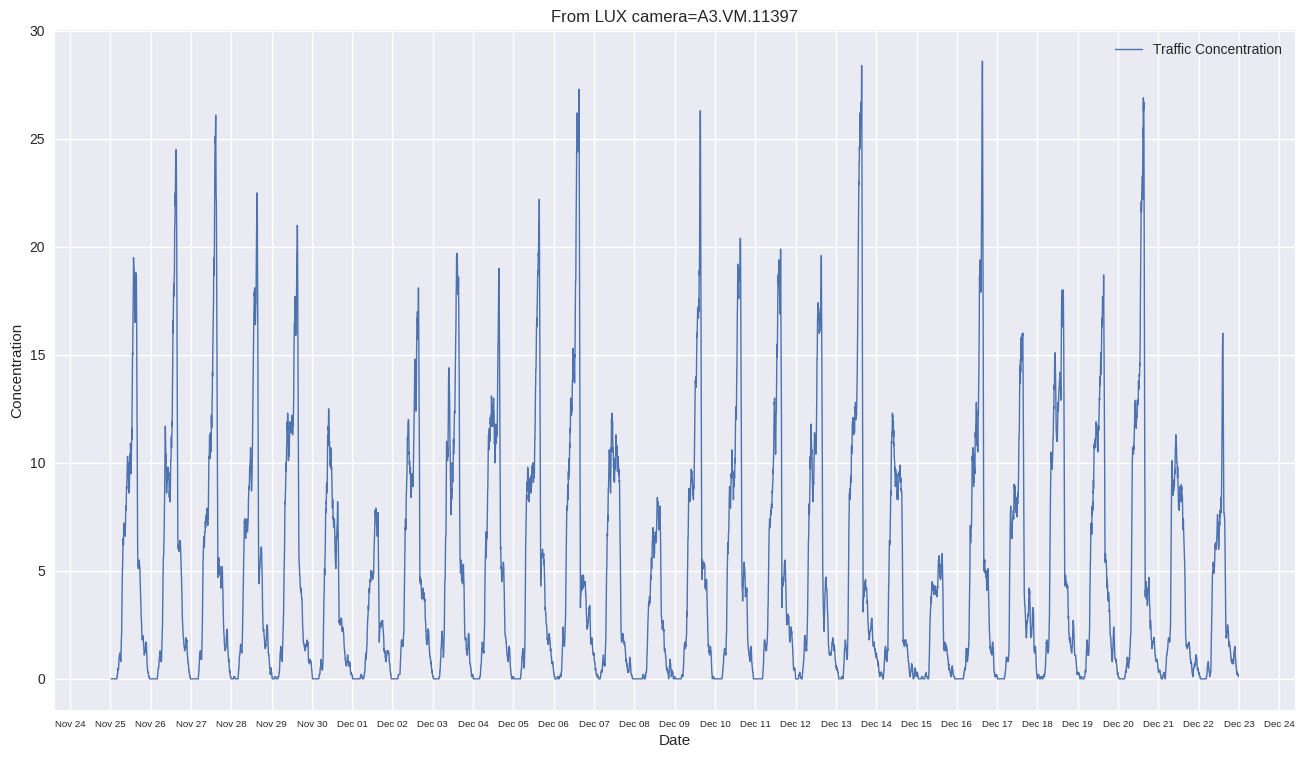

In [11]:
plot_long_serie(fromLux_rolling_traf,title='From LUX camera={}'.format(fromLuxCam),label='Traffic Concentration',xlabel='Date',ylabel='Concentration')


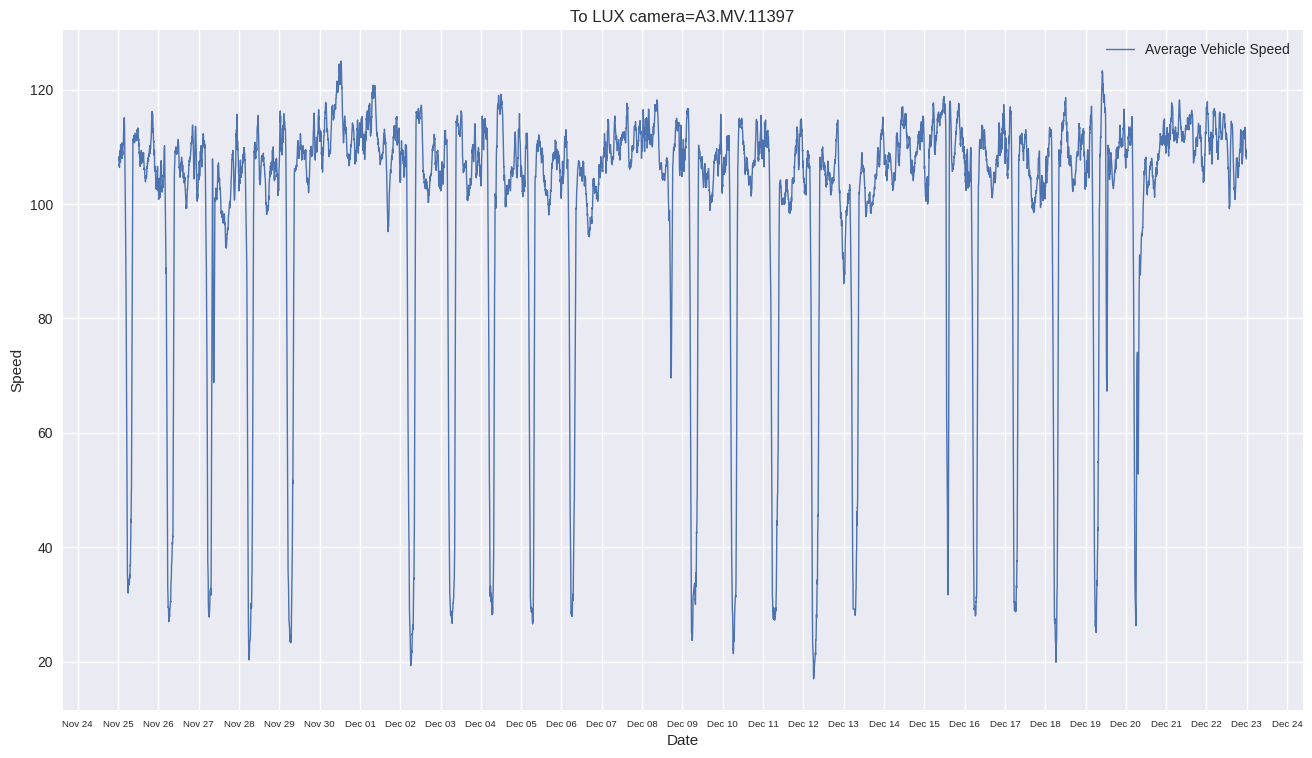

In [12]:
plot_long_serie(toLux_rolling_avg,title='To LUX camera={}'.format(toLuxCam),label='Average Vehicle Speed',xlabel='Date',ylabel='Speed')

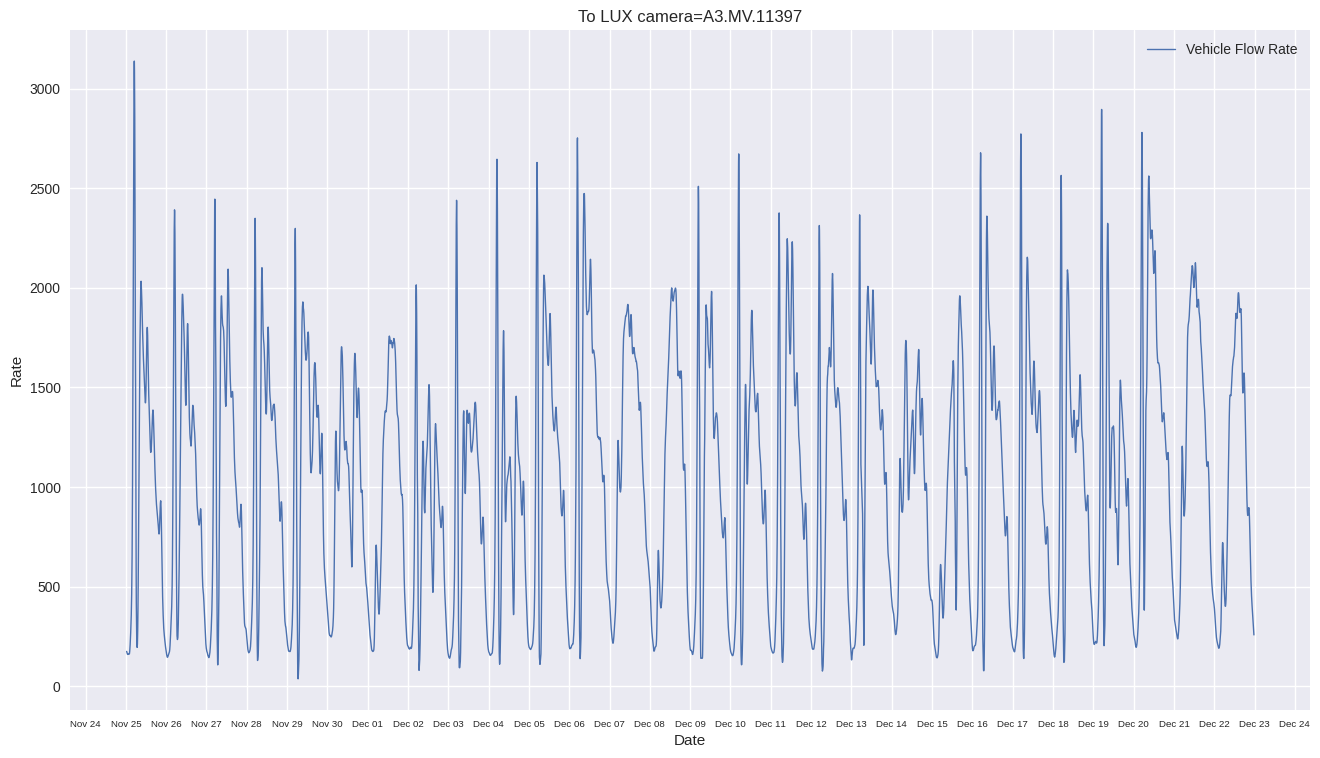

In [13]:
plot_long_serie(toLux_rolling_flow,title='To LUX camera={}'.format(toLuxCam),label='Vehicle Flow Rate',xlabel='Date',ylabel='Rate')

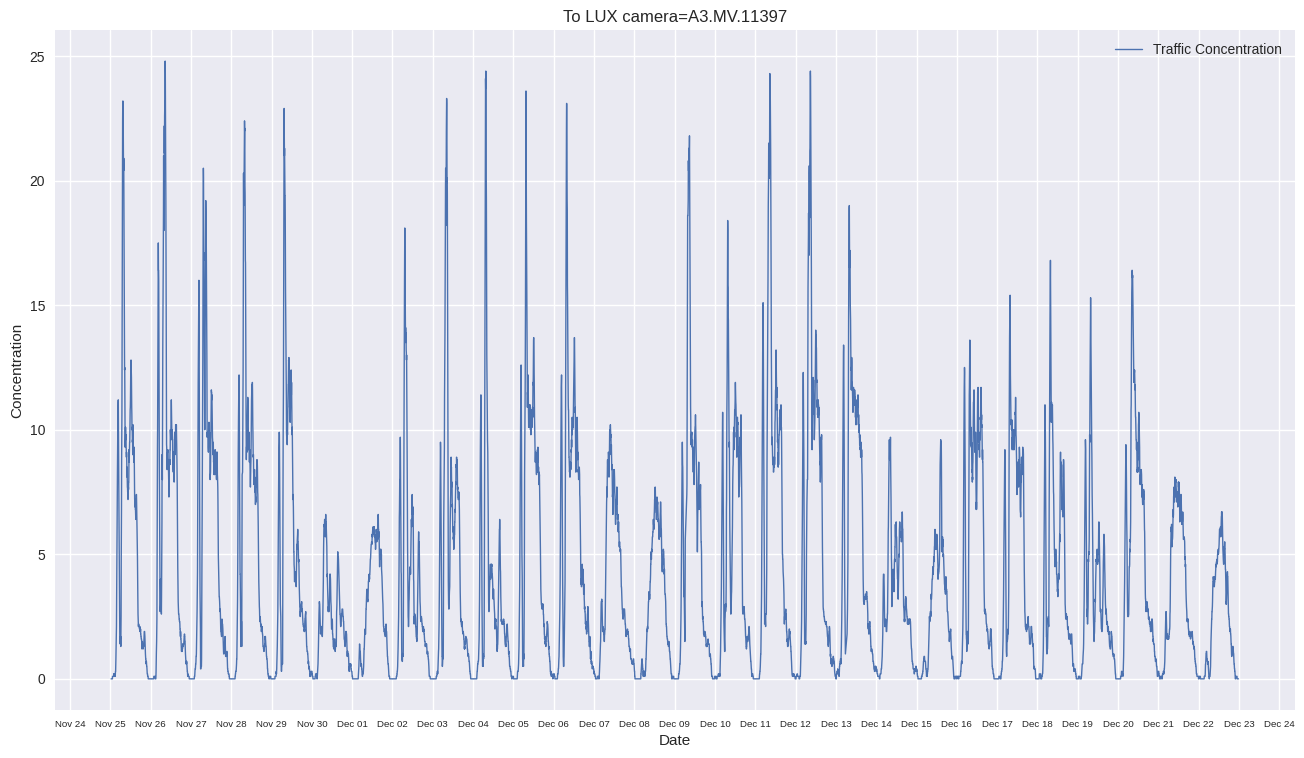

In [14]:
plot_long_serie(toLux_rolling_traf,title='To LUX camera={}'.format(toLuxCam),label='Traffic Concentration',xlabel='Date',ylabel='Concentration')

## See the traffic jams

> &#171;If we plot the data per day, towards Luxembourg at the top, then Luxembourg at the bottom, we can clearly see the traffic jams in the morning and in the evening for the days of the week&#187;

### Average speed by day, to Luxembourg and from Luxembourg

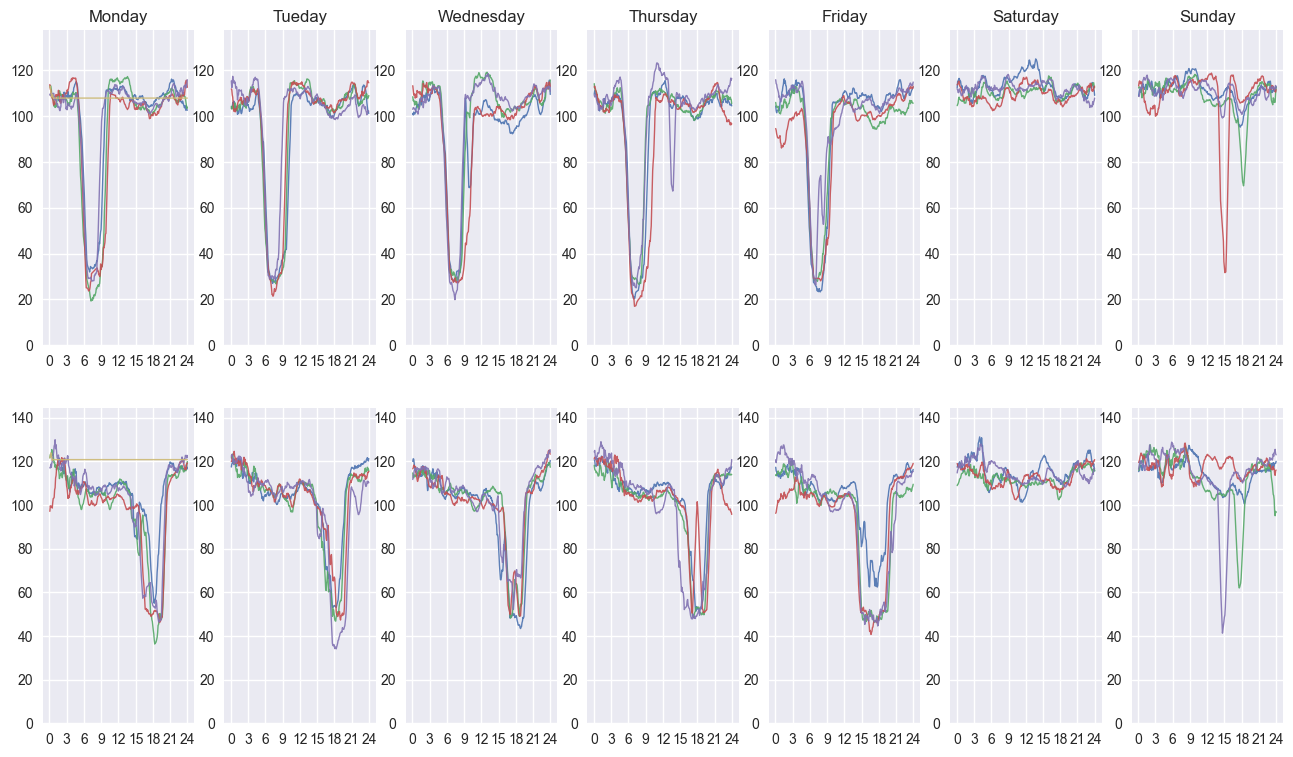

In [8]:
titles=['Monday','Tueday','Wednesday','Thursday','Friday','Saturday','Sunday']
plot_day_traffic(toLux_rolling_avg,fromLux_rolling_avg,titles)

### traffic flow by day, to Luxembourg and from Luxembourg

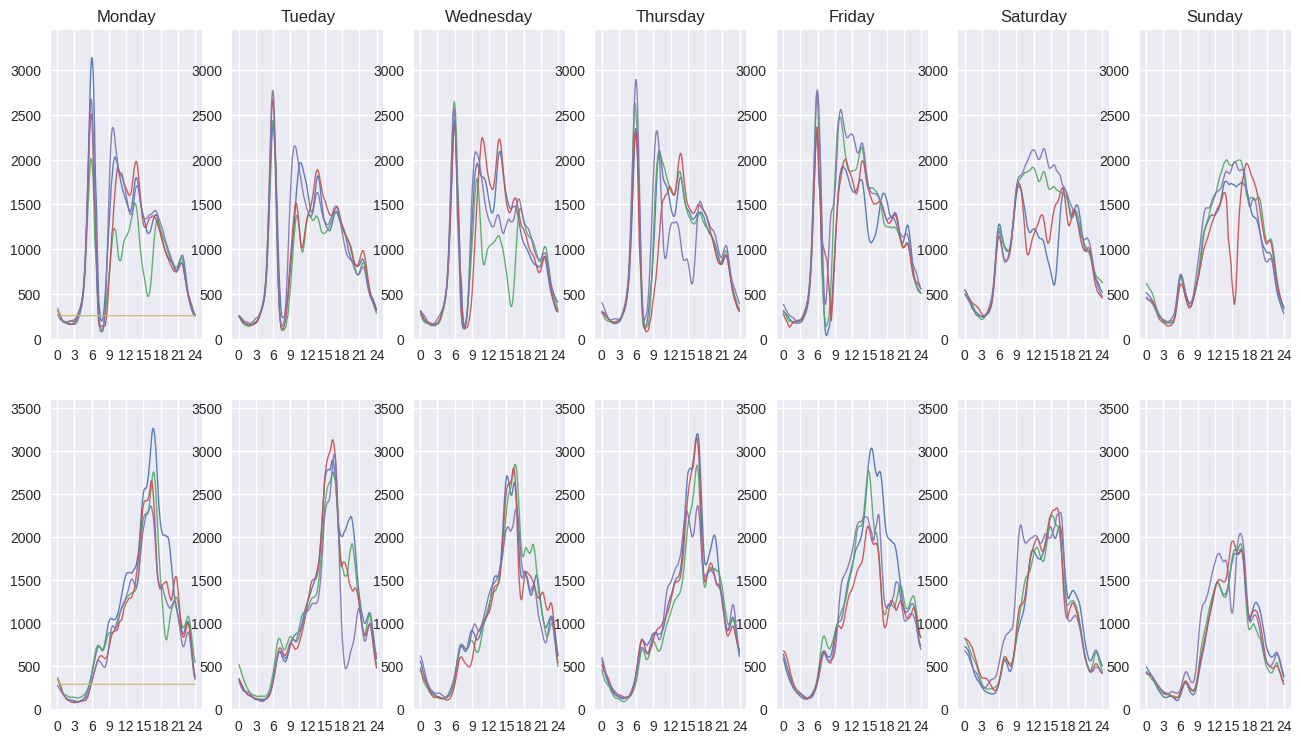

In [16]:
plot_day_traffic(toLux_rolling_flow,fromLux_rolling_flow,titles)

### Concentration, to Luxembourg and from Luxembourg

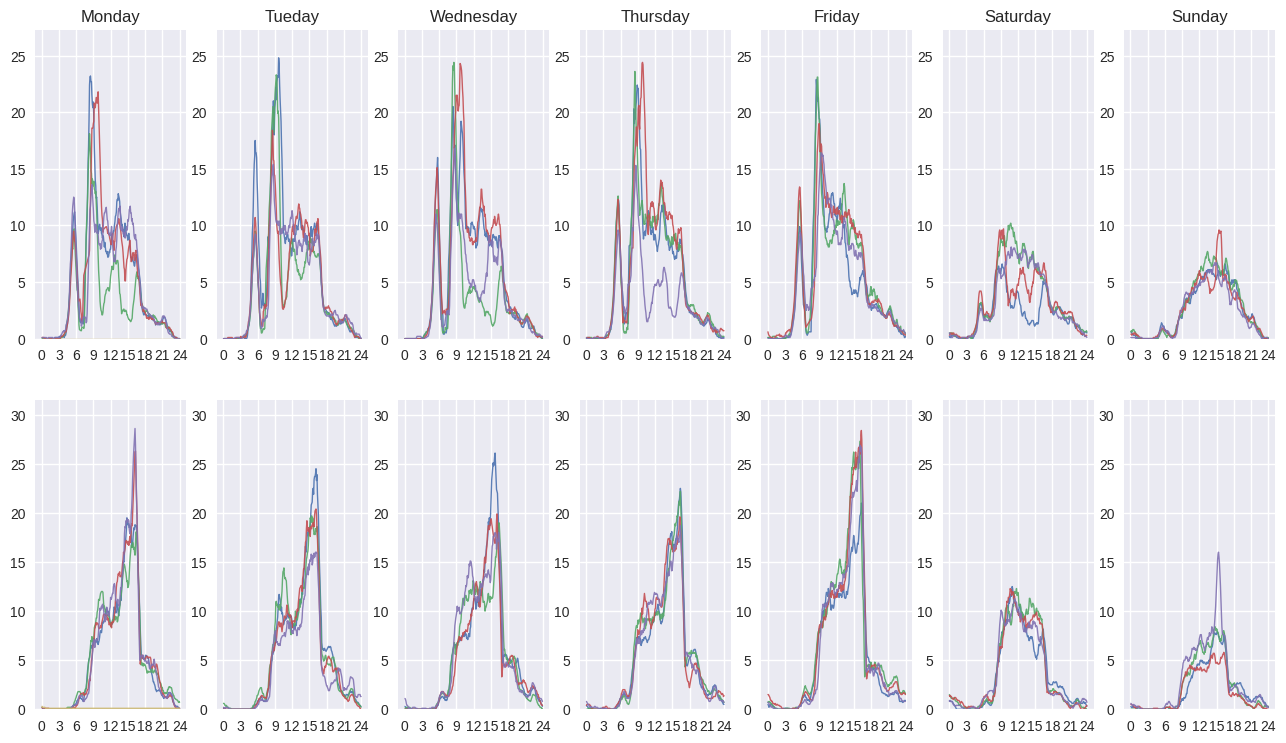

In [17]:
plot_day_traffic(toLux_rolling_traf,fromLux_rolling_traf,titles)

> &#171; It can also be interesting to observe how the traffic spreads along the highway: is the speed collapsing everywhere at the same time, or spreading along the highway  &#187;

In [9]:
for direction in ['outboundFromTown','inboundTowardsTown']:
    df = getFilteredDataByHighway(data,road,direction,fromDate,toDate)
    cams = camera.loc[(camera['road']==road)&(camera['direction']==direction)].sort_values(by=['direction_dist'])['id'].values
    datas=[]
    datas2=[]
    datas3=[]
    labels=[]
    for cam in cams:    
        temp=df.loc[(df['id']==cam)&(df.index.dayofweek.isin([0,1,2,3,4]))].copy()
        temp['minute']=temp.index.time
        temp.avgVehicleSpeed = temp.avgVehicleSpeed.rolling(window=3,center=True).mean()
        temp.vehicleFlowRate = temp.vehicleFlowRate.rolling(window=3,center=True).mean()
        temp.trafficConcentration = temp.trafficConcentration.rolling(window=3,center=True).mean()
        temp.dropna(inplace=True)
        data1 = temp.groupby('minute').mean()["avgVehicleSpeed"].copy()
        data1.index = data1.index.map(lambda x : x.strftime("%H:%M:%S"))
        datas.append(data1)
        data2 = temp.groupby('minute').mean()["vehicleFlowRate"].copy()
        data2.index = data2.index.map(lambda x : x.strftime("%H:%M:%S"))
        datas2.append(data2)
        data3 = temp.groupby('minute').mean()["trafficConcentration"].copy()
        data3.index = data3.index.map(lambda x : x.strftime("%H:%M:%S"))
        datas3.append(data3)
        labels.append(cam)
        
    # plot_mult(datas,labels,'Date','avgVehicleSpeed')    
    # plot_mult(datas2,labels,'Date','vehicleFlowRate')     
    # plot_mult(datas3,labels,'Date','vehicleFlowRate') 


# Prediction of indicators with Random forest

This first analysis focuses on the prediction of indicators. These three simple indicators (Yes / No) are as follows:
- 20% decrease in speed (compared to now) in 15 minutes.
- 60% drop in speed (relative to overall average speed) within 15 minutes.
- 60% drop in speed and flow (compared to the overall average) in 15 minutes.

These three indicators attempt to qualify respectively a slowing down, a potential traffic jam, more certainly a traffic jam.

To train the model, the following features are used :
At a moment t, for a camera,
- Average speed in km/h
- Traffic concentration in percentage
- Traffic flow in number of cars per hour
- The average speed for the camera 1km upstream
- The concentration of traffic for the camera 1km upstream
- Traffic flow for the camera 1km upstream
- Day of the week number
- Weekend: Yes / No
- Hour of day
- Speed change in %, between t and (t - 5 minutes), between (t - 5 minutes) and (t - 10 minutes) and between (t - 10 minutes) and (t - 15 minutes)
- Evolution of the flow in %, between t and (t - 5 minutes), between (t - 5 minutes) and (t - 10 minutes) and between (t - 10 minutes) and (t - 15 minutes)
- Evolution of the concentration in %, between t and (t - 5 minutes), between (t - 5 minutes) and (t - 10 minutes) and between (t - 10 minutes) and (t - 15 minutes)
- Exponential weighted average of the speed over the last 15 minutes
- Exponential weighted average of the concentration over the last 15 minutes
- Exponential weighted average of the stream over the last 15 minutes

The preliminary prediction tests brought the following two observations:
- Training only one model for all cameras at the same time does not give a good result. The dynamics of each point of the motorway are different.
- In the features, if we take only the camera data, the 15-minute predictions are unreliable. Therefore, the data from the upstream camera has been added.


In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score,SCORERS
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.preprocessing import MinMaxScaler

In [11]:
## Generate X and y
######################################################
def generateDf(dataIn,cam,cam1):
    df0 = getFilteredData(dataIn,cam)
    df1 = getFilteredData(dataIn,cam1)
    df1 = df1[['avgVehicleSpeed', 'vehicleFlowRate']]
    col_rename = {}
    for col in df1.columns:
        col_rename[col]='prev_station_' + col
    
    df1.rename(columns=col_rename,inplace=True)
    df = df0.join(df1)
    df=df[['avgVehicleSpeed', 'vehicleFlowRate','trafficConcentration','dayofweek','hour','prev_station_avgVehicleSpeed', 'prev_station_vehicleFlowRate']].copy()
    df['isWeekend'] = df['dayofweek'].map(lambda x : 0 if x < 5 else 1)

    # Diff %
    for i in range(1,backward+1):
         df['avgDiff'+str(i)] = df['avgVehicleSpeed'].shift(i-1)/ df['avgVehicleSpeed'].shift(i) - 1
         df['avgDiff'+str(i)].replace([np.inf, -np.inf], np.nan,inplace=True)
         df['avgDiff'+str(i)].fillna(method='bfill')
         df['flowDiff'+str(i)] = df['vehicleFlowRate'].shift(i-1)/ df['vehicleFlowRate'].shift(i) - 1
         df['flowDiff'+str(i)].replace([np.inf, -np.inf], np.nan,inplace=True)
         df['flowDiff'+str(i)].fillna(method='bfill')
         df['flowTraffic'+str(i)] = df['trafficConcentration'].shift(i-1)/ df['trafficConcentration'].shift(i) - 1
         df['flowTraffic'+str(i)].replace([np.inf, -np.inf], np.nan,inplace=True)
         df['flowTraffic'+str(i)].fillna(method='bfill')
         
    # EWL
    df['EWMavg']=df['avgVehicleSpeed'].ewm(span=3, adjust=False).mean()
    df['EWMflow']=df['vehicleFlowRate'].ewm(span=3, adjust=False).mean()
    df['EWMtraffic']=df['trafficConcentration'].ewm(span=3, adjust=False).mean()
    return df

def generateXYspeed20(df):    
    df['ydiff'] = df['avgVehicleSpeed'].shift(forward)/df['avgVehicleSpeed'] - 1    
    df['y'] = 0
    df.loc[df['ydiff']<-0.2,['y']]=1
    df.dropna(inplace=True)
    y = df['y']
    X = df.drop(['y','ydiff'], axis=1)
    return X , y

def generateXYspeedUnder(df):    
    mean = df['avgVehicleSpeed'].mean()
    df['ydiff'] = df['avgVehicleSpeed'].shift(forward)
    df['y'] = 0
    df.loc[df['ydiff']<mean*0.6,['y']]=1
    df.dropna(inplace=True)
    y = df['y']
    X = df.drop(['y','ydiff'], axis=1)
    return X , y

def generateXYspeedAndFlowUnder(df):    
    means = df['avgVehicleSpeed'].mean()
    meanf = df['vehicleFlowRate'].mean()
    df['ydiffSpeed'] = df['avgVehicleSpeed'].shift(forward)
    df['ydiffFlow'] = df['vehicleFlowRate'].shift(forward)
    df['y'] = 0
    df.loc[(df['ydiffSpeed']<means*0.6) &(df['ydiffFlow']<meanf*0.6),['y']]=1
    df.dropna(inplace=True)
    y = df['y']
    X = df.drop(['y','ydiffSpeed','ydiffFlow'], axis=1)
    return X , y

def print_metrics(y_true,y_pred):
    conf_mx = confusion_matrix(y_true,y_pred)
    print(conf_mx)
    print (" Accuracy    : ", accuracy_score(y_true,y_pred))
    print (" Precision   : ", precision_score(y_true,y_pred))
    print (" Sensitivity : ", recall_score(y_true,y_pred))




In [21]:
# def train_model(X,y):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
#     start = timer()
#     forest = RandomForestClassifier(max_depth = 10, n_estimators = 500, random_state = 42)
#     random_forest = forest.fit(X_train,y_train)
#     end = timer()
    
#     y_pred = random_forest.predict(X_train)
#     print ("------------------------------------------")
#     print ("TRAIN")
#     print_metrics(y_train,y_pred)
#     importances = list(zip(random_forest.feature_importances_, X.columns))
#     importances.sort(reverse=True)
#     print([x for (_,x) in importances[0:5]])
#     y_pred = random_forest.predict(X_test)
#     print ("------------------------------------------")
#     print ("TEST")
#     print_metrics(y_test,y_pred)
    
#     return random_forest 

In [16]:
cam = 'A3.MV.10437'
cam1= 'A3.MV.11397'   

forward = -3
backward = 3    
df = generateDf(data,cam,cam1)


print ('camera :',cam)
print ("---------------------------------------------------------------")
print ("Predict 20% speed drop")
X,y = generateXYspeed20(df)
# model = train_model(X,y)

print ("---------------------------------------------------------------")
print ("Predict speed less than 60% of the average speed")
X,y = generateXYspeedUnder(df)
# model = train_model(X,y)

print ("---------------------------------------------------------------")
print ("Predict speed anf flow less than 60% of the average")
X,y = generateXYspeedAndFlowUnder(df)
# model = train_model(X,y)


camera : A3.MV.10437
---------------------------------------------------------------
Predict 20% speed drop
---------------------------------------------------------------
Predict speed less than 60% of the average speed
---------------------------------------------------------------
Predict speed anf flow less than 60% of the average


## Which indicator gives the most reliable predictions?
- 20% decrease in speed (compared to now) in 15 minutes.
- 60% drop in speed (relative to overall average speed) within 15 minutes.
- 60% drop in speed and flow (compared to the overall average) in 15 minutes.

let's test over a couple of cameras

In [18]:
# def train_model_and_get_metrics(X,y):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
#     start = timer()
#     forest = RandomForestClassifier(max_depth = 10, n_estimators = 500, random_state = 42)
#     random_forest = forest.fit(X_train,y_train)
#     end = timer()
#     y_pred = random_forest.predict(X_test)
#     #print (" Accuracy    : ", accuracy_score(y_true,y_pred))
#     #print (" Precision   : ", precision_score(y_true,y_pred))
#     #print (" Sensitivity : ", recall_score(y_true,y_pred))    
#     return [accuracy_score(y_test,y_pred), precision_score(y_test,y_pred),recall_score(y_test,y_pred)]

In [ ]:
# cams = camera.loc[(camera['road']=='A3')&(camera['direction']=='inboundTowardsTown')].sort_values(by=['direction_dist'],ascending=False)['id'].values
# prev_cam_dict = getPreviousCamDict(camera)
# speed20=[]
# speedUnder=[]
# speedAndFlowUnder=[]
# for cam in (cams[1:]):
#     cam1 = prev_cam_dict.get(cam)
#     print ('camera :',cam)
#     df = generateDf(data,cam,cam1)
#     X,y = generateXYspeed20(df)
#     speed20.append(train_model_and_get_metrics(X,y))
#     X,y = generateXYspeedUnder(df)
#     speedUnder.append(train_model_and_get_metrics(X,y))
#     X,y = generateXYspeedAndFlowUnder(df)
#     speedAndFlowUnder.append(train_model_and_get_metrics(X,y))
# speed20df = pd.DataFrame(speed20, columns = ['Accurancy', 'precision','recall'])
# speedUnderdf = pd.DataFrame(speedUnder, columns = ['Accurancy', 'precision','recall'])
# speedAndFlowUnderdf = pd.DataFrame(speedAndFlowUnder, columns = ['Accurancy', 'precision','recall'])

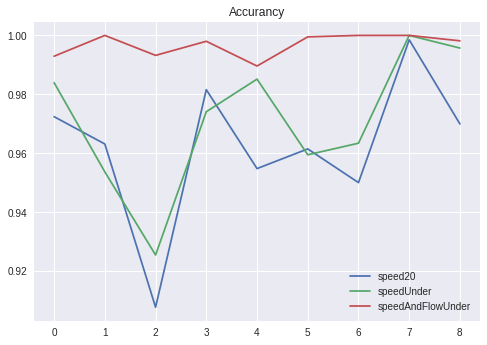

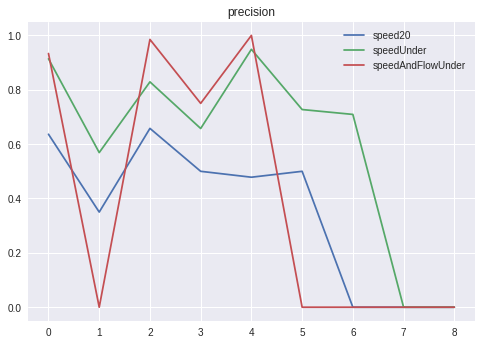

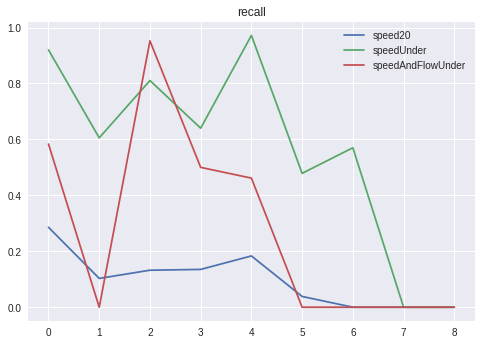

In [25]:
# for col in ['Accurancy', 'precision','recall']:
#     plt.plot(speed20df[col], label='speed20')    
#     plt.plot(speedUnderdf[col], label='speedUnder')
#     plt.plot(speedAndFlowUnderdf[col], label='speedAndFlowUnder')
#     plt.title(col)
#     plt.legend()
#     plt.show()

> &#171; The indicator that have the best results is **60% drop in speed (relative to overall average speed) within 15 minutes**&#187;

# Time serie forecasting

> &#171; The question is, can we predict one or more future values from a window into the past using a LSTM ? &#187;

**The window has 10 steps in past**
```
WINDOW = 10
FORECAST = 1
```
---

IN:

---

The Features IN are composed of 4 series (
- avgVehicleSpeed of the camera 
- vehicleFlowRate of the camera 
- avgVehicleSpeed of the previous camera
- vehicleFlowRate of the previous camera


---

OUT :  

---

target feature : average speed or vehicleFlowRate

FORECAST = 1 (+5 minutes), 2 (+10 minutes) or 3 (+15 minutes)


In [17]:
def getSequences(sequence, backward, forward=1):
    X, y = list(), list()
    for i in range(len(sequence)-(backward+forward-1)):
        if forward > 1:
            seq_x, seq_y = sequence[i:i+backward], sequence[i+backward:i+backward+forward]
        else:
            seq_x, seq_y = sequence[i:i+backward], sequence[i+backward]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [14]:
# Parameters
pindexMin = '2000-01-01 00:00:00+0000'
pindexMax = '2030-01-01 00:00:00+0000'

cam = 'A3.VM.8246' 
cam1 = 'A3.VM.7280'

WINDOW = 10
FORECAST = 3

In [18]:
# Build features dataframe
df0 = getFilteredData(data,cam,indexMin=pindexMin,indexMax=pindexMax)
df0=df0[['avgVehicleSpeed', 'vehicleFlowRate']]
df1 = getFilteredData(data,cam1,indexMin=pindexMin,indexMax=pindexMax)
df1=df1[['avgVehicleSpeed', 'vehicleFlowRate']]
    
df1.rename(columns={'avgVehicleSpeed' : 'pre_avgVehicleSpeed', 'vehicleFlowRate' : 'pre_vehicleFlowRate'},inplace=True)
df = df0.join(df1,how='inner')
df.dropna(inplace=True)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

X, _ = getSequences(scaled, backward = WINDOW , forward= FORECAST )
_ , ySpeed = getSequences(scaled[:,0], backward = WINDOW , forward= FORECAST )
_ , yFlow = getSequences(scaled[:,1], backward = WINDOW , forward= FORECAST )

print("X shape", X.shape," - y shape ", y.shape)

X_train = X[1000:]
X_test = X[:1000]
ySpeed_train = ySpeed[1000:]
ySpeed_test = ySpeed[:1000]
yFlow_train = yFlow[1000:]
yFlow_test = yFlow[:1000]

X shape (10497, 10, 4)  - y shape  (7781,)


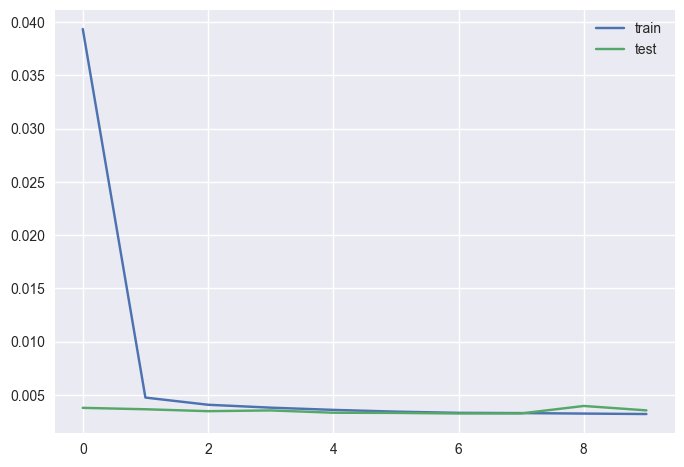

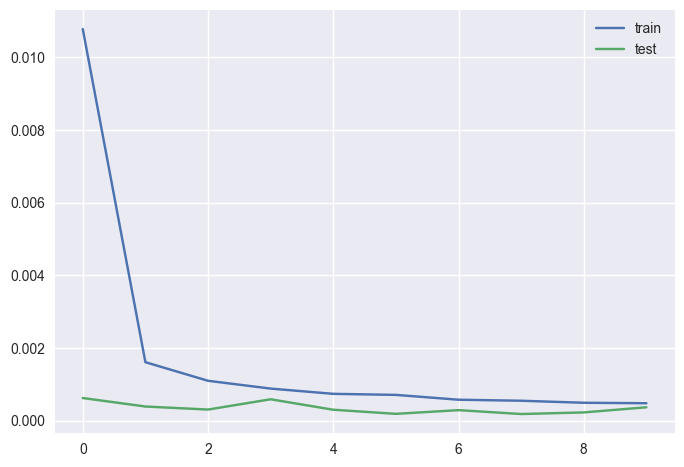

In [19]:
# Train the model
def trainTheModel(X_train,y_train):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(FORECAST))
    model.compile(loss='mse', optimizer='adam')
    early_stop = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10
    )   
    history = model.fit(
        X_train,y_train, 
        epochs=10, 
        batch_size=64, 
        validation_split=0.05,
        shuffle=True,
        callbacks=[early_stop],
        verbose=0
        )            

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    return model

modelSpeed = trainTheModel(X_train,ySpeed_train)
modelFlow = trainTheModel(X_train,yFlow_train)

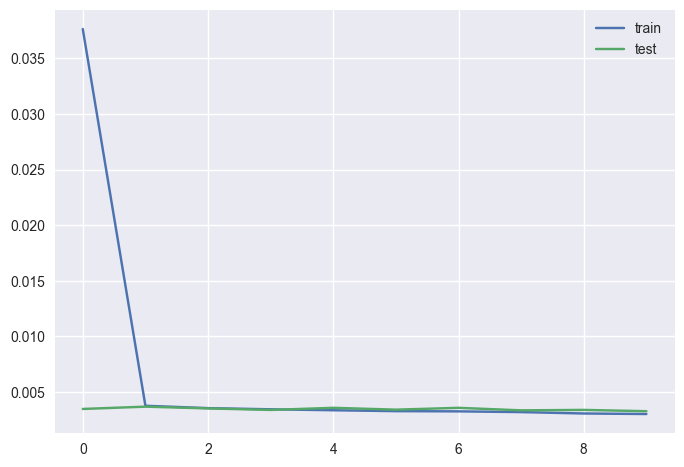

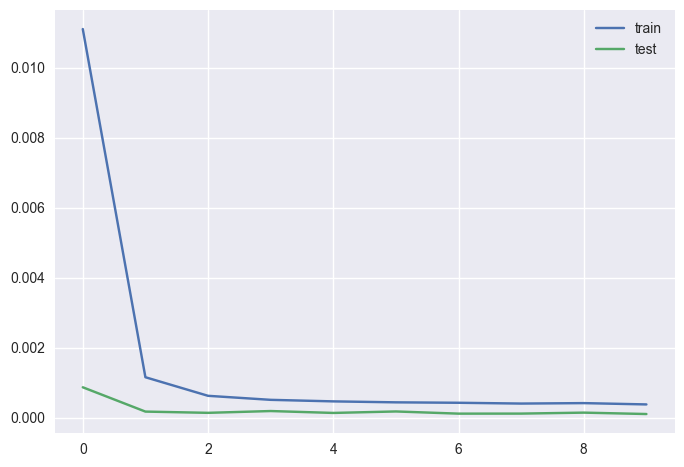

In [24]:
# Train the model
def trainTheModel_GRU(X_train,y_train):
    model = keras.Sequential()
    model.add(keras.layers.GRU(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(FORECAST))
    model.compile(loss='mse', optimizer='adam')
    early_stop = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10
    )   
    history = model.fit(
        X_train,y_train, 
        epochs=10, 
        batch_size=64, 
        validation_split=0.05,
        shuffle=True,
        callbacks=[early_stop],
        verbose=0
        )            

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    return model

modelSpeed_gru = trainTheModel_GRU(X_train,ySpeed_train)
modelFlow_gru = trainTheModel_GRU(X_train,yFlow_train)

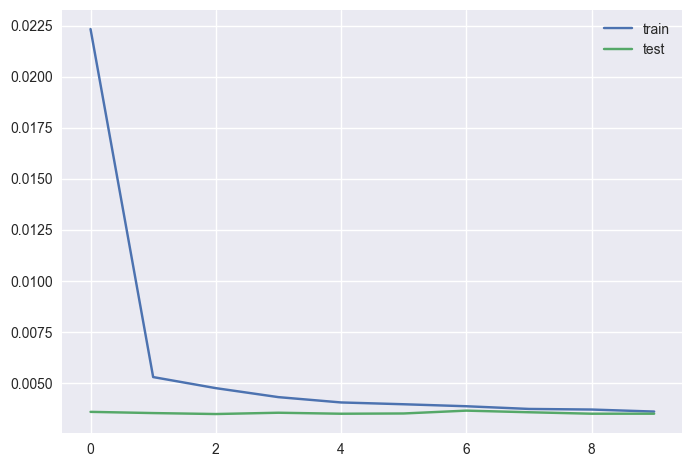

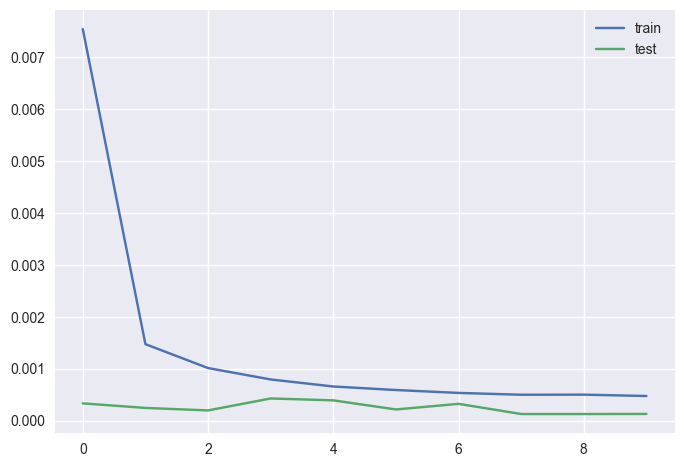

In [26]:
# Train the model
def trainTheModel_RNN(X_train,y_train):
    model = keras.Sequential()
    model.add(keras.layers.RNN(keras.layers.LSTMCell(128), input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(FORECAST))
    model.compile(loss='mse', optimizer='adam')
    early_stop = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10
    )   
    history = model.fit(
        X_train,y_train, 
        epochs=10, 
        batch_size=64, 
        validation_split=0.05,
        shuffle=True,
        callbacks=[early_stop],
        verbose=0
        )            

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    return model

modelSpeed_rnn = trainTheModel_RNN(X_train,ySpeed_train)
modelFlow_rnn = trainTheModel_RNN(X_train,yFlow_train)

In [28]:
# Evaluate the results with test data
ySpeed_pred = modelSpeed.predict(X_test)
yFlow_pred = modelFlow.predict(X_test)

for i in [0,1,2]:
    print("RMSE for Speed Prediction + {} minutes= {}".format(i*5+5,measure_rmse(ySpeed_test[:,i], (ySpeed_pred[:,i]))))

for i in [0]:
    print("MAE for Speed Prediction + {} minutes= {}".format(i*5+5,mean_absolute_error(ySpeed_test[:,i], (ySpeed_pred[:,i]))))

for i in [0]:
    print("R2 for Speed Prediction + {} minutes= {}".format(i*5+5,r2_score(ySpeed_test[:,i], (ySpeed_pred[:,i]))))

# for i in [0,1,2]:
#     print("RMSE for Flow Prediction + {} minutes= {}".format(i*5+5,measure_rmse(yFlow_test[:,i], (yFlow_pred[:,i]))))

print("---------------------------------GRU-------------------------")
ySpeed_pred_gru = modelSpeed_gru.predict(X_test)
yFlow_pred_gru = modelFlow_gru.predict(X_test)

for i in [0]:
    print("RMSE for Speed Prediction + {} minutes= {}".format(i*5+5,measure_rmse(ySpeed_test[:,i], (ySpeed_pred_gru[:,i]))))

for i in [0]:
    print("MAE for Speed Prediction + {} minutes= {}".format(i*5+5,mean_absolute_error(ySpeed_test[:,i], (ySpeed_pred_gru[:,i]))))

for i in [0]:
    print("R2 for Speed Prediction + {} minutes= {}".format(i*5+5,r2_score(ySpeed_test[:,i], (ySpeed_pred_gru[:,i]))))

# for i in [0,1,2]:
#     print("RMSE for Flow Prediction + {} minutes= {}".format(i*5+5,measure_rmse(yFlow_test[:,i], (yFlow_pred_gru[:,i]))))

print("---------------------------------RNN-------------------------")
ySpeed_pred_rnn = modelSpeed_rnn.predict(X_test)
yFlow_pred_rnn = modelFlow_rnn.predict(X_test)

for i in [0]:
    print("RMSE for Speed Prediction + {} minutes= {}".format(i*5+5,measure_rmse(ySpeed_test[:,i], (ySpeed_pred_rnn[:,i]))))

for i in [0]:
    print("MAE for Speed Prediction + {} minutes= {}".format(i*5+5,mean_absolute_error(ySpeed_test[:,i], (ySpeed_pred_rnn[:,i]))))

for i in [0]:
    print("R2 for Speed Prediction + {} minutes= {}".format(i*5+5,r2_score(ySpeed_test[:,i], (ySpeed_pred_rnn[:,i]))))

# for i in [0,1,2]:
#     print("RMSE for Flow Prediction + {} minutes= {}".format(i*5+5,measure_rmse(yFlow_test[:,i], (yFlow_pred_gru[:,i]))))

32/32 [==============================] - 0s 4ms/step
RMSE for Speed Prediction + 5 minutes= 0.05576195578509768
RMSE for Speed Prediction + 10 minutes= 0.05914549227037897
RMSE for Speed Prediction + 15 minutes= 0.0610397423854529
MAE for Speed Prediction + 5 minutes= 0.03701927717248877
R2 for Speed Prediction + 5 minutes= 0.8864860171377614
---------------------------------GRU-------------------------
32/32 [==============================] - 0s 3ms/step
RMSE for Speed Prediction + 5 minutes= 0.0564117082015418
MAE for Speed Prediction + 5 minutes= 0.0380501596745807
R2 for Speed Prediction + 5 minutes= 0.8838252174826152
---------------------------------RNN-------------------------
32/32 [==============================] - 0s 5ms/step
RMSE for Speed Prediction + 5 minutes= 0.05768140183053905
MAE for Speed Prediction + 5 minutes= 0.03864133459063885
R2 for Speed Prediction + 5 minutes= 0.8785367270185999


In [29]:
ySpeed_pred_rnn = modelSpeed_rnn.predict(X_test)
yFlow_pred_rnn = modelFlow_rnn.predict(X_test)

32/32 [==============================] - 0s 4ms/step


In [31]:
ySpeed_pred_gru = modelSpeed_gru.predict(X_test)
yFlow_pred_gru = modelFlow_gru.predict(X_test)


32/32 [==============================] - 0s 4ms/step


In [30]:
ySpeed_pred = modelSpeed.predict(X_test)
yFlow_pred = modelFlow.predict(X_test)

32/32 [==============================] - 0s 5ms/step


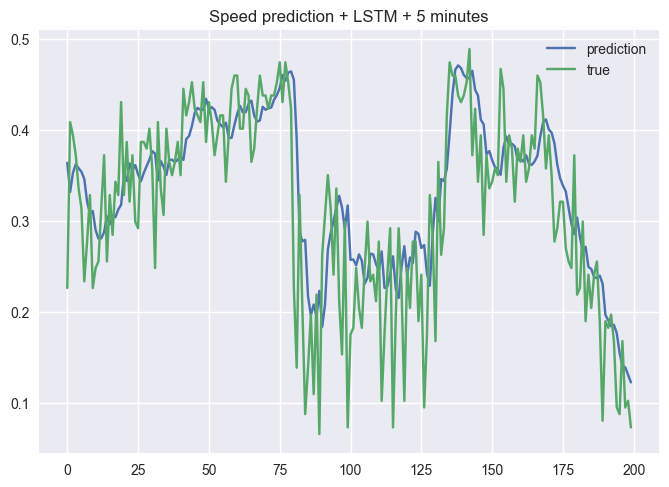

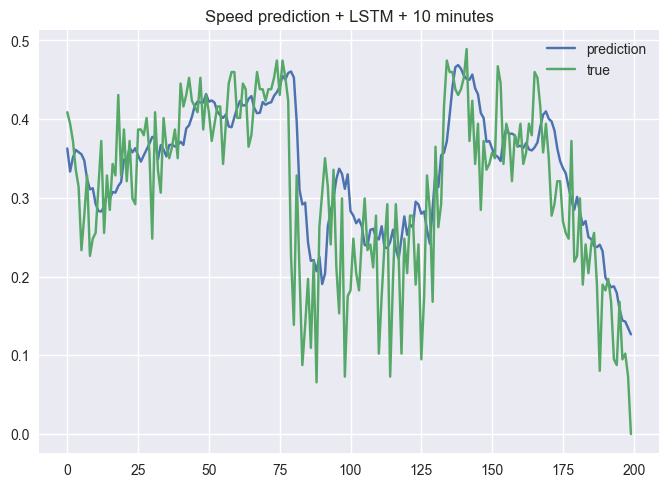

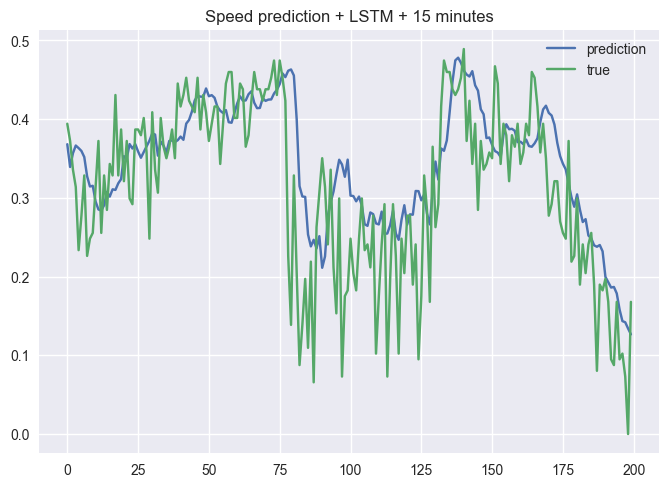

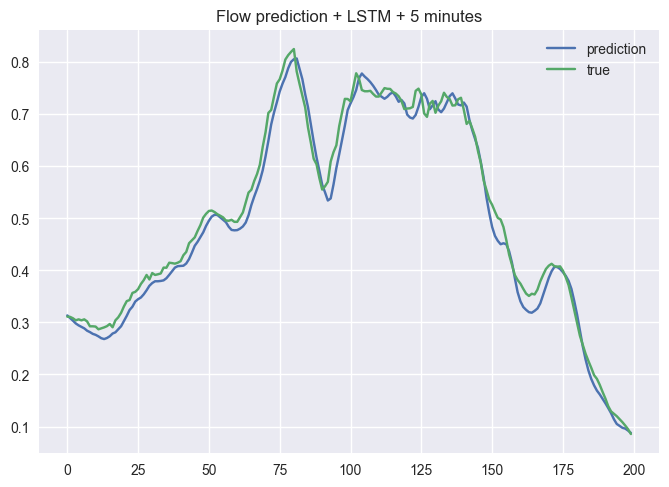

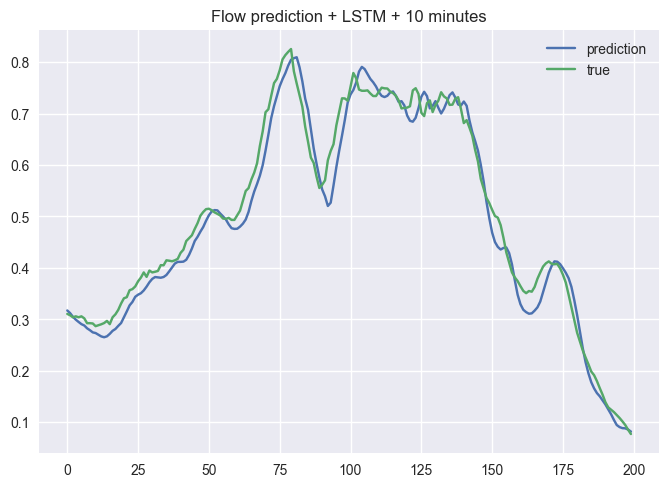

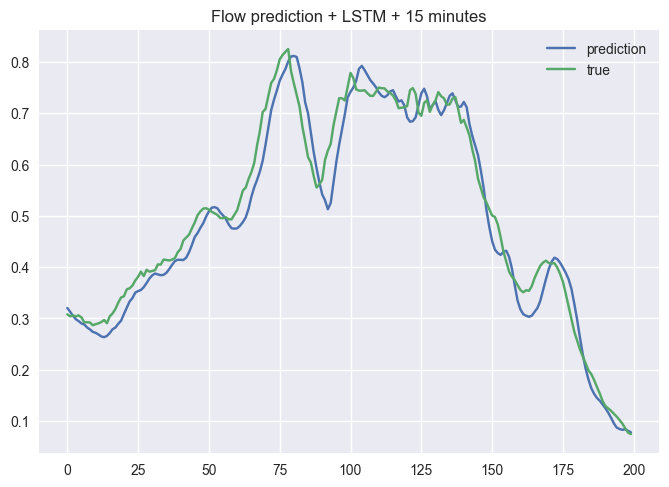

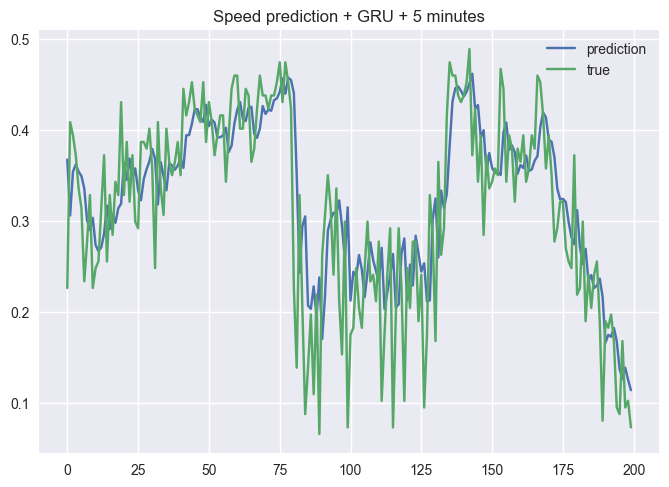

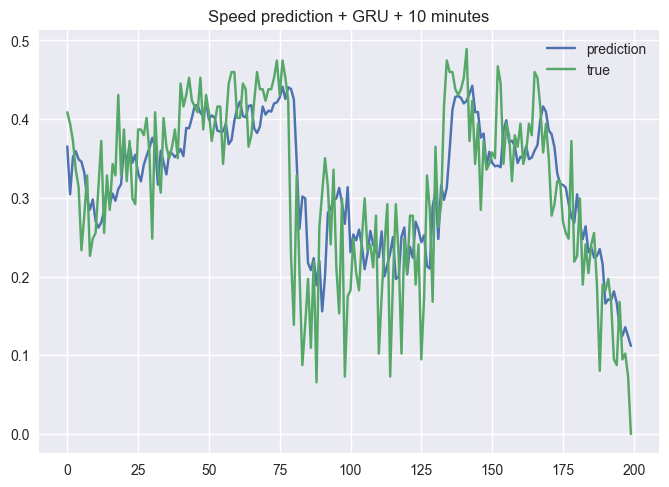

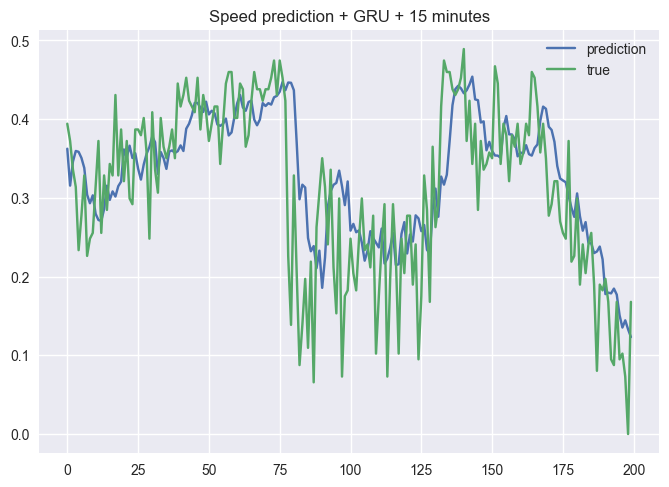

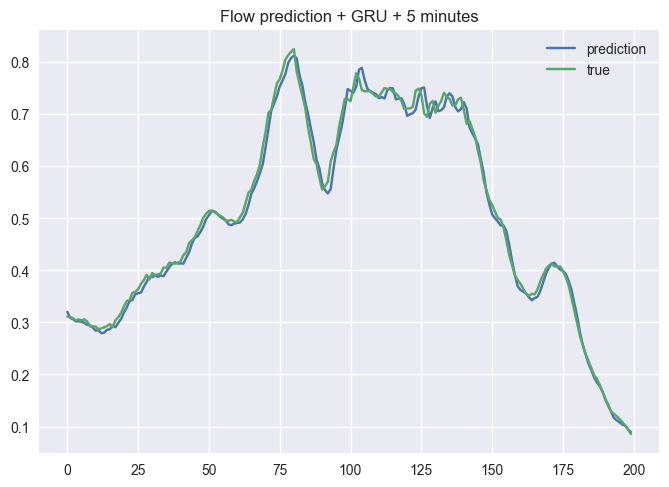

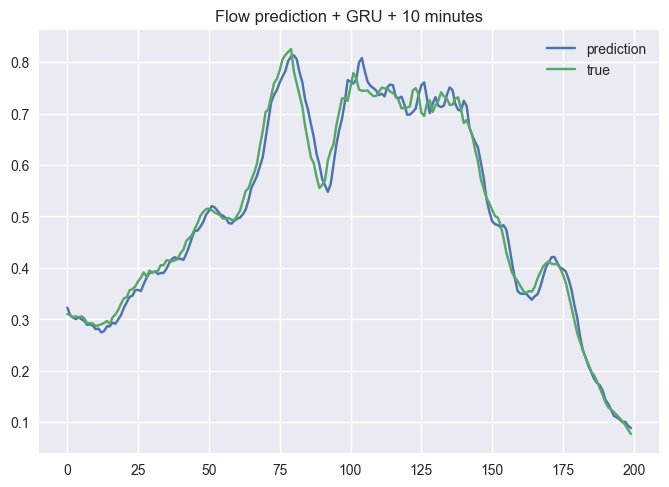

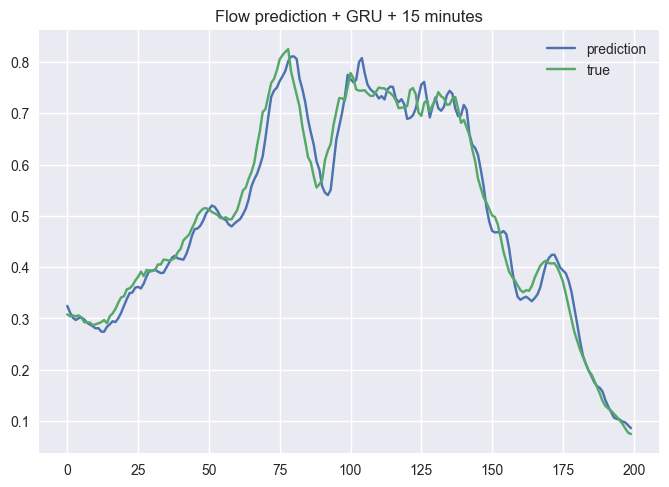

In [34]:
iStart=100
iStop=200
for i in [0,1,2]:
    plt.plot(ySpeed_pred[:iStop,i], label='prediction')    
    plt.plot(ySpeed_test[:iStop,i], label='true')
    plt.title('Speed prediction + LSTM + {} minutes'.format(i*5+5))
    plt.legend()
    plt.show()
for i in [0,1,2]:
    plt.plot(yFlow_pred[:iStop,i], label='prediction')    
    plt.plot(yFlow_test[:iStop,i], label='true')
    plt.title('Flow prediction + LSTM + {} minutes'.format(i*5+5))
    plt.legend()
    plt.show()


for i in [0,1,2]:
    plt.plot(ySpeed_pred_gru[:iStop,i], label='prediction')    
    plt.plot(ySpeed_test[:iStop,i], label='true')
    plt.title('Speed prediction + GRU + {} minutes'.format(i*5+5))
    plt.legend()
    plt.show()
for i in [0,1,2]:
    plt.plot(yFlow_pred_gru[:iStop,i], label='prediction')    
    plt.plot(yFlow_test[:iStop,i], label='true')
    plt.title('Flow prediction + GRU + {} minutes'.format(i*5+5))
    plt.legend()
    plt.show()

# Conclusion

The two indicators that give the best performance at 15 minutes are:
- Random Forest : 60% drop in speed (relative to overall average speed) within 15 minutes.
- LSTM : traffic flow forecast


The preliminary prediction tests brought the following two observations:

- it's better to train one model by camera.
- In the features, it's better to take account of upstream camera data